NASA Jet Fan Engine Remaining Usable Life(RUL)

In [1]:
# %%

%matplotlib inline

from FirstSteps import column_converter,feature_skew_check
from stall_margin_formulas import HPCStallMargin
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np





In [2]:
FD001_data_tuple = column_converter('CMAPSSData/train_FD001.txt')



no failures converting dataframe columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20630 entries, 0 to 20629
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Engine                                20630 non-null  int64  
 1   Cycles                                20630 non-null  int64  
 2   Operational Setting 1                 20630 non-null  float64
 3   Operational Setting 2                 20630 non-null  float64
 4   Operational Setting 3                 20630 non-null  float64
 5   Fan inlet temperature ◦R              20630 non-null  float64
 6   LPC outlet temperature ◦R             20630 non-null  float64
 7   HPC outlet temperature ◦R             20630 non-null  float64
 8   LPT outlet temperature ◦R             20630 non-null  float64
 9   Fan inlet Pressure psia               20630 non-null  float64
 10  bypass-duct pressure psia             206

Skewness of Fan inlet temperature ◦R: 0.0
Skewness of LPC outlet temperature ◦R: 0.316583501137655
Skewness of HPC outlet temperature ◦R: 0.3089193176181448
Skewness of LPT outlet temperature ◦R: 0.4431150548728743
Skewness of Fan inlet Pressure psia: 0.0
Skewness of bypass-duct pressure psia: -6.916635002907901
Skewness of HPC outlet pressure psia: -0.3942606916976628
Skewness of Physical fan speed rpm: 0.47934011995066556
Skewness of Physical core speed rpm: 2.5553469250442564
Skewness of Engine pressure ratioP50/P2: 0.0
Skewness of HPC outlet Static pressure psia: 0.4692823094660817
Skewness of Ratio of fuel flow to Ps30 pps/psia: -0.4423533166145076
Skewness of Corrected fan speed rpm: 0.46972290073323913
Skewness of Corrected core speed rpm: 2.3724704578719185
Skewness of Bypass Ratio : 0.3881823266382687
Skewness of Burner fuel-air ratio: 0.0
Skewness of Bleed Enthalpy: 0.35304226645162856
Skewness of Required fan speed: 0.0
Skewness of Required fan conversion speed: 0.0
Skewness

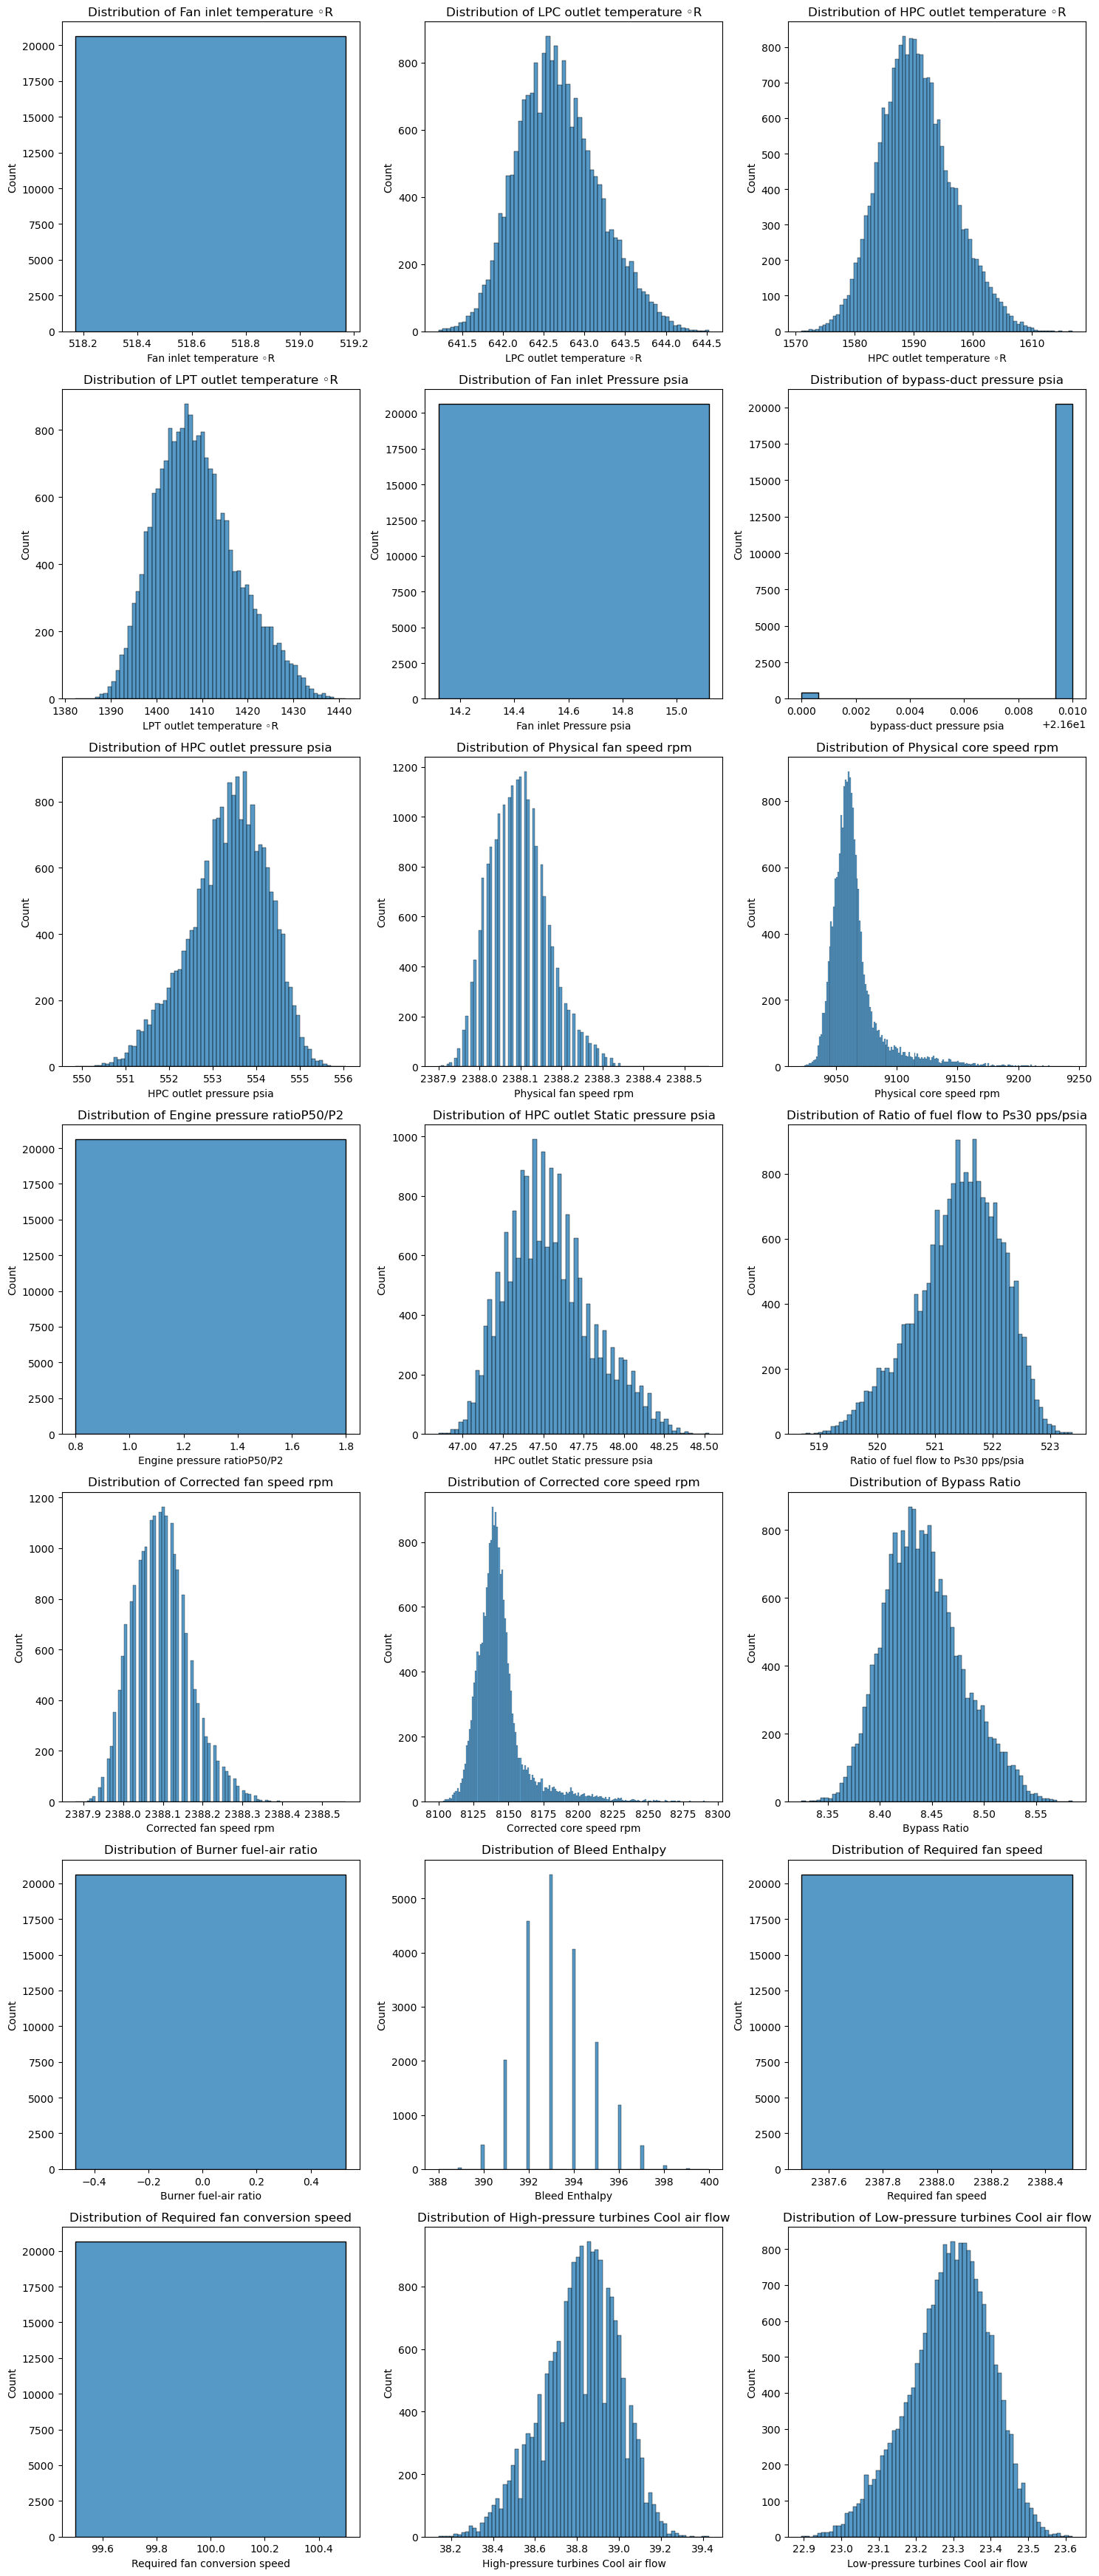

In [3]:
feature_skew_check(FD001_data_tuple[0],FD001_data_tuple[1])
FD001_data = FD001_data_tuple[0]

The data is a mix of normal and uniform distributions. In the time-series application, I decomposed all the sensor data to determine residuals and generate QQ plots for each sensor feature. The analysis can be found in the timeSeries_explore.ipynb notebook.

I decided not to normalize the 'Physical core speed rpm' and 'Corrected core speed rpm' due to the Augmented Dickey-Fuller (ADF) test scores and the residuals from the time-series decomposition. Despite the skewed distributions of these features, the ADF scores indicated stationarity, and the prediction squared differences showed no significant bias in these features. Additionally, the model performed well within the presence of heteroscedasticity.

Since this data is intended to reflect real-world scenarios, I have decided not to normalize these two features at this time, despite the observed skewness.

This is my first attempt at predicting the remaining useful life (RUL). I will approach this exercise using concepts I am familiar with and deep dive into domain-specific topics. In computer science, we have ways of evaluating the health of computer components and software. Each component of a system has health metrics that indicate stress, load, deterioration, and so on. Although I'm not a domain expert on jet engines, I will assume that the components of a jet fan engine have similar indicators, expressed through meaningful metrics that can be used to understand the health of that component.

Modern jet engines generally operate at a pressure ratio of 40 to 55:1 at sea level (our test case). Generally speaking, a higher overall pressure ratio implies higher efficiency. The downside to higher efficiency, however, is heat. As air travels through the compressor, it reaches temperatures that can cause the deterioration of the compressor blades. This is especially true for the last compressor stage (source: Wikipedia). I will find other components that impact engine performance and outline them at a later time.

The workflow for the jet fan engine is as follows:

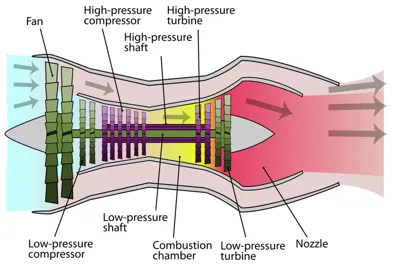


Referring back to my approach of using meaningful metrics to understand component health, the RUL-Based-Prediction.pdf helped me learn the industry-appropriate language: "RUL-Similarity-Hybrid." The RUL-Similarity-Hybrid approach uses both historical data and a model with conditions that indicate failure through calculations. Digesting this information gave me a sense of confidence that, although I was operating outside of my area of expertise, I shared a like-minded methodology for solving this challenge. Additionally, terms like "prognostics estimation" provided a clearer understanding of the concept of remaining useful life (RUL). After reviewing documents in the "Reference Domain Artifacts" directory, I gained insights on how to apply sensor data to industry-recognized formulas for high-pressure compressor health indicators. I have provided those formulas below. 



Gas_Turbine_BestPractices.pdf(page 49)


1. Efficiency Loss:
$$\eta_{\text{loss}} = \eta_0 - \eta$$

2. Current Efficiency:
$$\eta = \frac{T_{\text{outlet\_ideal}} - T_{\text{inlet}}}{T_{\text{outlet\_actual}} - T_{\text{inlet}}}$$

3. Ideal Outlet Temperature:
$$T_{\text{outlet\_ideal}} = T_{\text{inlet}} \times \left( \frac{P_{\text{outlet}}}{P_{\text{inlet}}} \right)^{\frac{\gamma - 1}{\gamma}}$$

4. Flow Loss:
$$\text{Flow Loss} = \dot{m}_0 - \dot{m}$$

5. Corrected Flow:
$$\dot{m}_{\text{corrected}} = \sqrt{\frac{T_{\text{inlet}}}{T_{\text{std}}}} \times \frac{P_{\text{std}}}{P_{\text{inlet}}}$$

6. Stall Margin
$$\text{Stall Margin} = a \times \eta_{\text{loss}} + b \times \text{Flow Loss} + c$$

I will use these calculations as features for my model.



Please see 'Stall_margin_formulas.py to understand how these formulas were calculated and feature engineerd into the datatset. 


In [4]:
hpc = HPCStallMargin()
FD001_data_formulas = hpc.calculate_health_metrics(FD001_data)
stall_margin_failure_threshold = hpc.stall_margin_failure_threshold

In [5]:
print(FD001_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20630 entries, 0 to 20629
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Engine                                20630 non-null  int64  
 1   Cycles                                20630 non-null  int64  
 2   Operational Setting 1                 20630 non-null  float64
 3   Operational Setting 2                 20630 non-null  float64
 4   Operational Setting 3                 20630 non-null  float64
 5   Fan inlet temperature ◦R              20630 non-null  float64
 6   LPC outlet temperature ◦R             20630 non-null  float64
 7   HPC outlet temperature ◦R             20630 non-null  float64
 8   LPT outlet temperature ◦R             20630 non-null  float64
 9   Fan inlet Pressure psia               20630 non-null  float64
 10  bypass-duct pressure psia             20630 non-null  float64
 11  HPC outlet pres

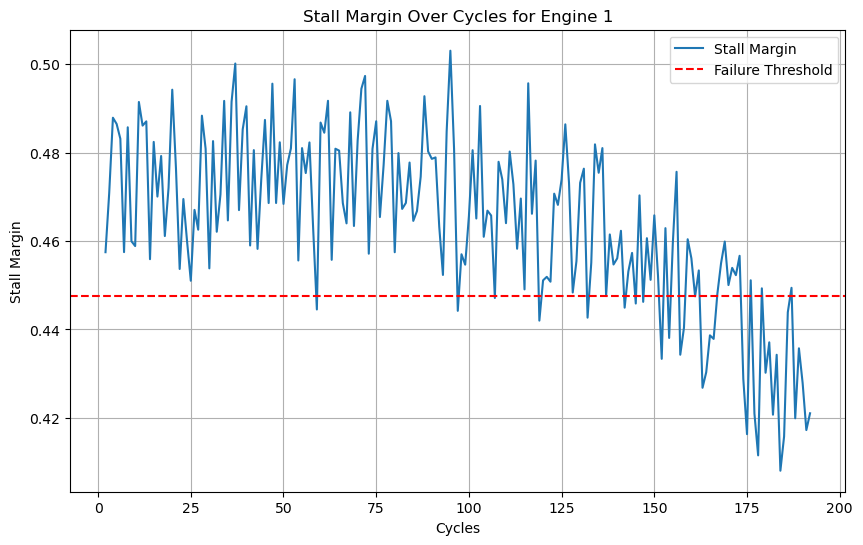

In [6]:
engine_id = 1
engine_data = FD001_data[FD001_data['Engine'] == engine_id]

plt.figure(figsize=(10, 6))
plt.plot(engine_data['Cycles'], engine_data['stall_margin'], label='Stall Margin')
plt.axhline(stall_margin_failure_threshold, color='red', linestyle='--', label='Failure Threshold')
plt.title(f'Stall Margin Over Cycles for Engine {engine_id}')
plt.xlabel('Cycles')
plt.ylabel('Stall Margin')
plt.legend()
plt.grid(True)
plt.show()




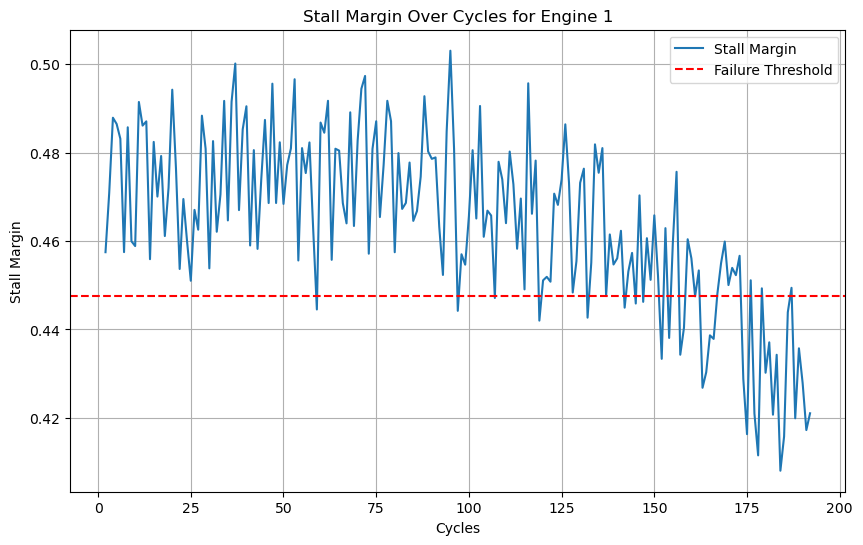

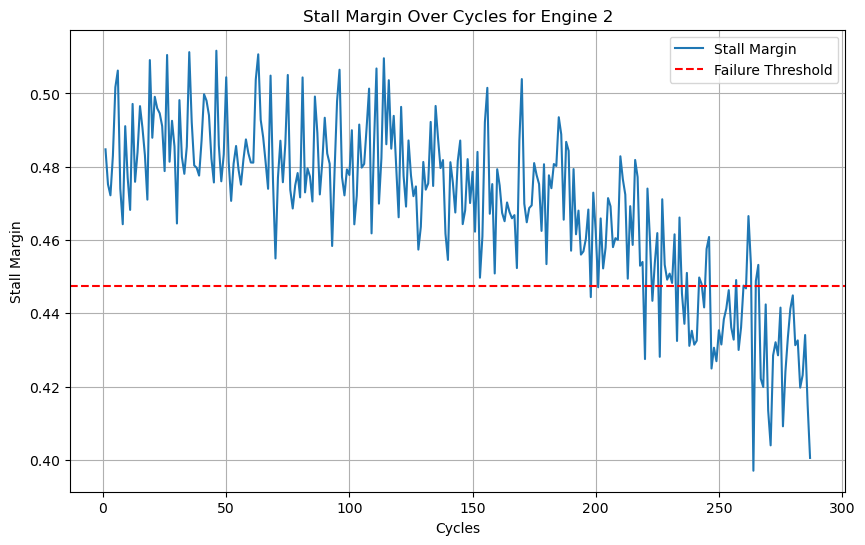

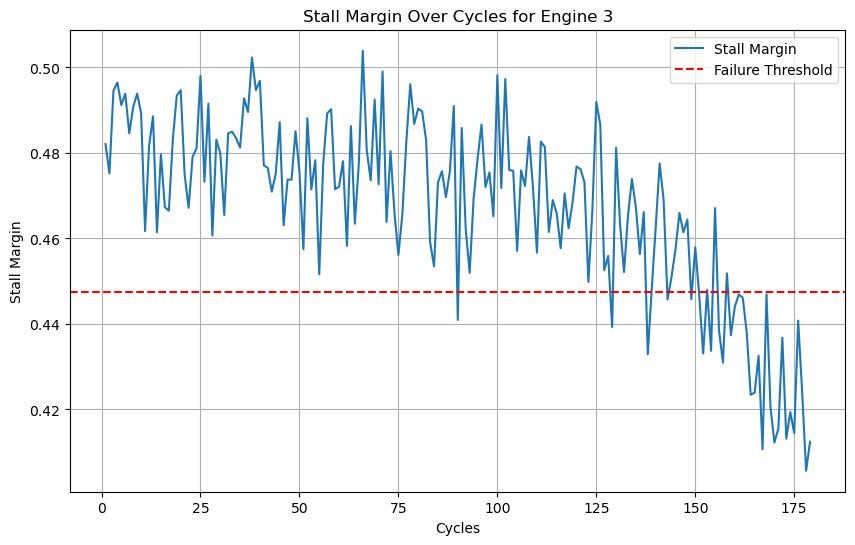

In [7]:


# Function to plot stall margin over cycles for each engine
def plot_stall_margin(engine_ids, df, failure_threshold):
    for engine_id in engine_ids:
        engine_data = df[df['Engine'] == engine_id]

        plt.figure(figsize=(10, 6))
        plt.plot(engine_data['Cycles'], engine_data['stall_margin'], label='Stall Margin')
        plt.axhline(failure_threshold, color='red', linestyle='--', label='Failure Threshold')
        plt.title(f'Stall Margin Over Cycles for Engine {engine_id}')
        plt.xlabel('Cycles')
        plt.ylabel('Stall Margin')
        plt.legend()
        plt.grid(True)
        plt.show()

# Assuming 'Engine' column identifies the engine number and 'Cycles' column identifies the cycle count
engine_ids = FD001_data['Engine'].unique()[:3]  # Select the first 10 engines

# Plot stall margin for the first 10 engines
plot_stall_margin(engine_ids, FD001_data, stall_margin_failure_threshold)


In [8]:
FD001_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20630 entries, 0 to 20629
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Engine                                20630 non-null  int64  
 1   Cycles                                20630 non-null  int64  
 2   Operational Setting 1                 20630 non-null  float64
 3   Operational Setting 2                 20630 non-null  float64
 4   Operational Setting 3                 20630 non-null  float64
 5   Fan inlet temperature ◦R              20630 non-null  float64
 6   LPC outlet temperature ◦R             20630 non-null  float64
 7   HPC outlet temperature ◦R             20630 non-null  float64
 8   LPT outlet temperature ◦R             20630 non-null  float64
 9   Fan inlet Pressure psia               20630 non-null  float64
 10  bypass-duct pressure psia             20630 non-null  float64
 11  HPC outlet pres

These are the wear ranges defined in the Damage Propagation Modeling.pdf
As you can see, HPT efficiency is listed here but not HCP. One is for the H-turbine and the other is for the H-compressor. I'm inferring that these two components have a high degree of correlation based on their function. 

| Parameter         | Initial Wear (%) | Wear 3000 Cycles (%) | Wear 6000 Cycles (%) |
|-------------------|------------------|----------------------|----------------------|
| Fan Efficiency    | -0.18            | -1.5                 | -2.85                |
| Fan Flow          | -0.26            | -2.04                | -3.65                |
| LPC Efficiency    | -0.62            | -1.46                | -2.61                |
| LPC Flow          | -1.01            | -2.08                | -4.00                |
| HPT Efficiency    | -0.48            | -2.63                | -3.81                |
| HPT Flow          | +0.08            | +1.76                | +2.57                |
| LPT Efficiency    | -0.10            | -0.54                | -1.08                |
| LPT Flow          | +0.08            | +0.26                | +0.42                |


In [9]:
#adding wear manifest ranges as features

FD001_data['Baseline_Efficiency']= hpc.Baseline_Efficiency
FD001_data['Initial_Wear_HPT_Efficiency'] = hpc.Initial_Wear_HPT_Efficiency
FD001_data['Initial_Wear_HPT_Flow'] = hpc.Initial_Wear_HPT_Flow

#Wear 3000 Cycles
FD001_data['Wear_HPT_Efficiency_3000'] = hpc.Wear_HPT_Efficiency_3000
FD001_data['Wear_HPT_Flow_3000'] = hpc.Wear_HPT_Flow_3000

#Wear 6000 Cycles
FD001_data['Wear_HPT_Efficiency_6000'] = hpc.Wear_HPT_Efficiency_6000
FD001_data['Wear_HPT_Flow_6000'] = hpc.Wear_HPT_Flow_6000



In [10]:
X = FD001_data[['Cycles','Baseline_Efficiency','Initial_Wear_HPT_Efficiency','Initial_Wear_HPT_Flow','Wear_HPT_Efficiency_3000','Wear_HPT_Flow_3000','Wear_HPT_Efficiency_6000','Wear_HPT_Flow_6000','Engine pressure ratioP50/P2']]
y = FD001_data['stall_margin']

scale = StandardScaler()
X_scale = scale.fit_transform(X)

In [11]:
lin_model = LinearRegression().fit(X_scale,y)
preds = lin_model.predict(X_scale)
absMean = mean_absolute_error(y,preds)
print(absMean)
#Calculate R2 score
r2_poly_lin = r2_score(y,preds)
print(f'r2 score is:{r2_poly_lin}')

0.013761562323998246
r2 score is:0.3226818237748452


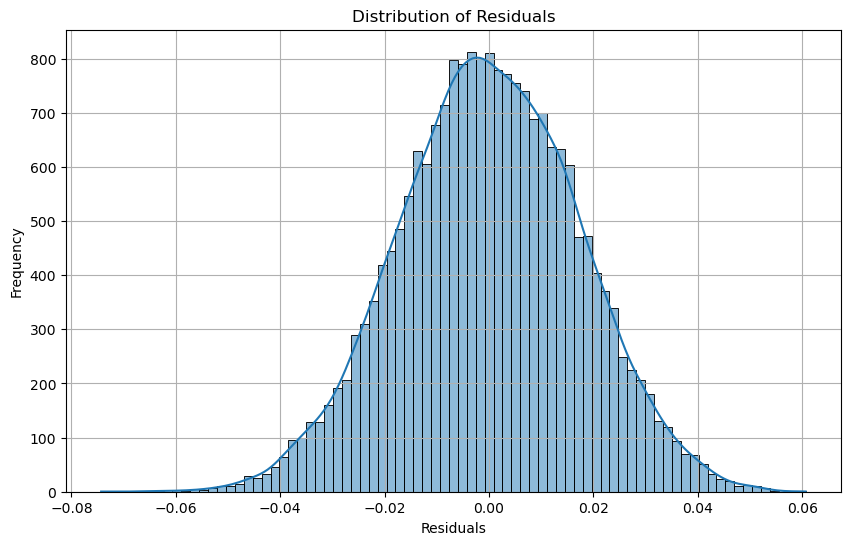

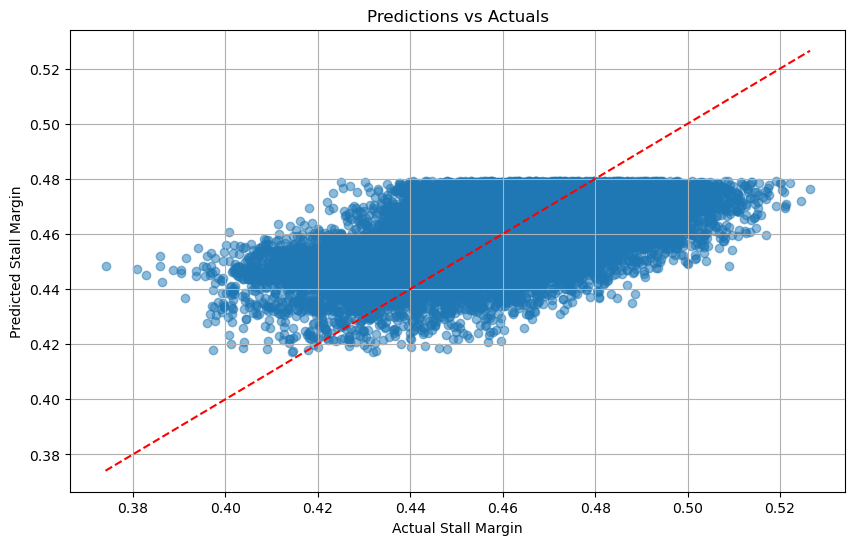

In [12]:
residuals = y - preds

# Plotting Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting Predictions vs. Actuals
plt.figure(figsize=(10, 6))
plt.scatter(y, preds, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')  # Identity line
plt.title('Predictions vs Actuals')
plt.xlabel('Actual Stall Margin')
plt.ylabel('Predicted Stall Margin')
plt.grid(True)
plt.show()

In [13]:
poly_pipe = Pipeline([('poly',PolynomialFeatures()),('lin',LinearRegression())]).fit(X_scale,y)


In [14]:
params ={
    'poly__degree':[2,3],
    'lin__fit_intercept': [True, False]
}

In [15]:
poly_grid = GridSearchCV(poly_pipe,param_grid=params,n_jobs=-1,cv=5).fit(X_scale,y)
best_params = poly_grid.best_params_
best_score = poly_grid.best_score_

In [16]:
print(best_params,best_score)

{'lin__fit_intercept': False, 'poly__degree': 3} 0.31779552785114484


Mean Absolute Error (Polynomial): 0.013578404416020306
r2 score is:0.34074361722867064


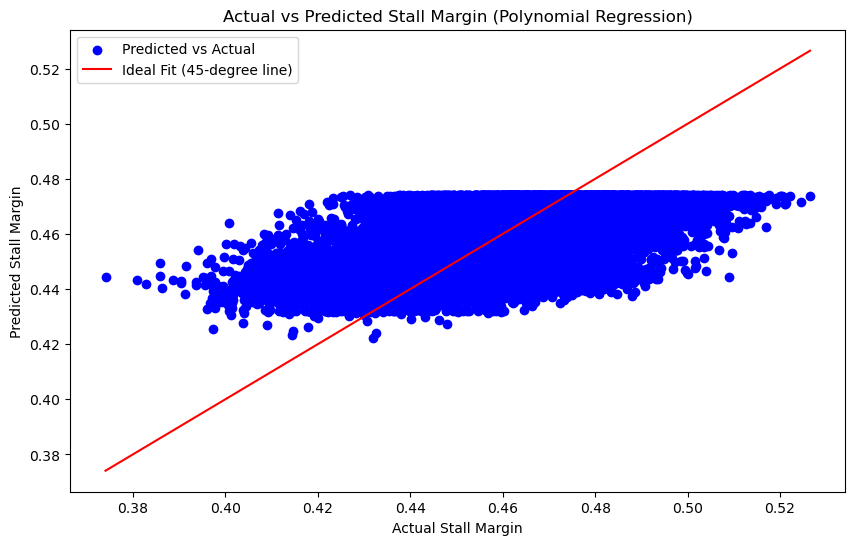

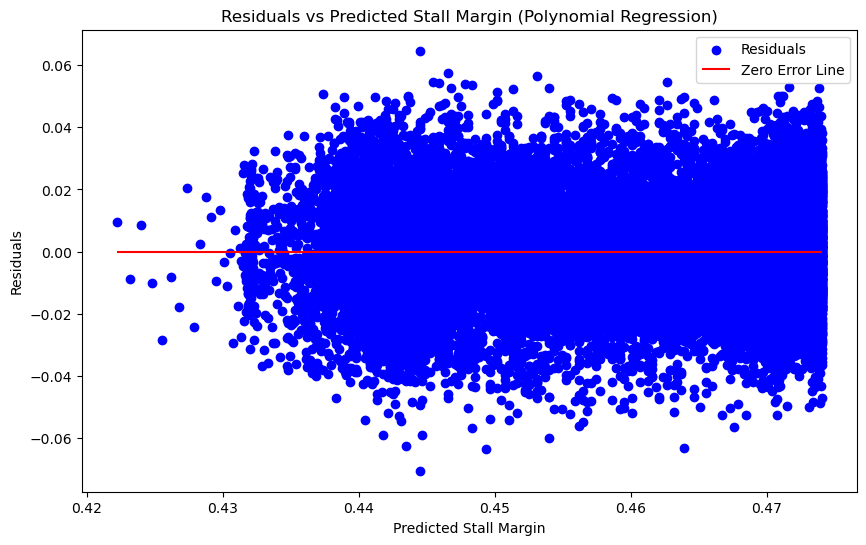

In [17]:
X = FD001_data[['Cycles','Baseline_Efficiency','Initial_Wear_HPT_Efficiency','Initial_Wear_HPT_Flow','Wear_HPT_Efficiency_3000','Wear_HPT_Flow_3000','Wear_HPT_Efficiency_6000','Wear_HPT_Flow_6000','Engine pressure ratioP50/P2']]
y = FD001_data['stall_margin']

# Create polynomial features
poly = PolynomialFeatures(degree=8,include_bias=False)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
poly_model = LinearRegression().fit(X_poly, y)

# Predict the stall margin using the model
y_poly_pred = poly_model.predict(X_poly)

# Calculate the mean absolute error
mae_poly = mean_absolute_error(y, y_poly_pred)
print(f'Mean Absolute Error (Polynomial): {mae_poly}')

#Calculate R2 score
r2_poly = r2_score(y,y_poly_pred)
print(f'r2 score is:{r2_poly}')

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y, y_poly_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', label='Ideal Fit (45-degree line)')
plt.xlabel('Actual Stall Margin')
plt.ylabel('Predicted Stall Margin')
plt.title('Actual vs Predicted Stall Margin (Polynomial Regression)')
plt.legend()
plt.show()

# Residuals plot
residuals = y - y_poly_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_poly_pred, residuals, color='blue', label='Residuals')
plt.hlines(y=0, xmin=min(y_poly_pred), xmax=max(y_poly_pred), color='red', label='Zero Error Line')
plt.xlabel('Predicted Stall Margin')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Stall Margin (Polynomial Regression)')
plt.legend()
plt.show()

My model is capturing data across the entire fleet so my actual vs. prediction plots have too much data and show no trend. Instead, I need to model according to single engine or the aggregate of the fleet.(I have to research how to do this). But so you can see my thought process I'll do my best to make better sense of the data. 

r2 score is:0.548754690405103
Stall margin breaches the threshold at cycle 162, predicted value 0.4468942799162093


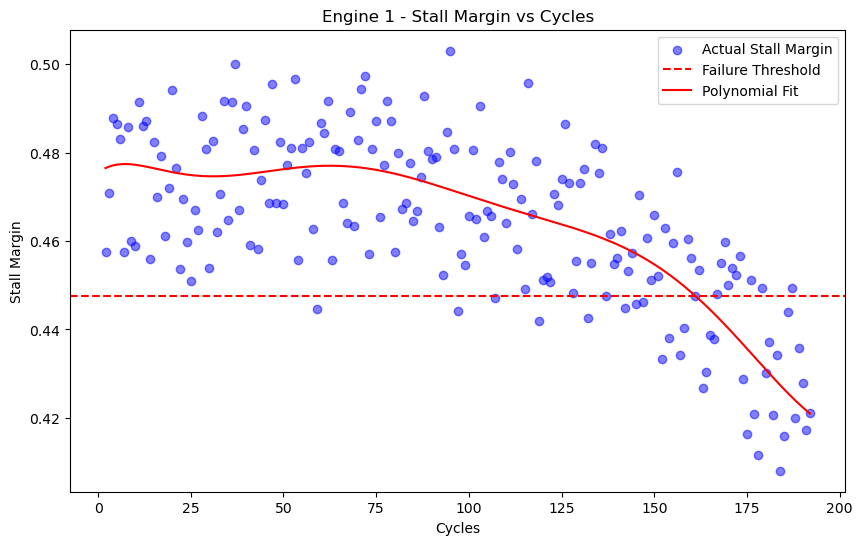

r2 score is:0.6893781406860082
Stall margin breaches the threshold at cycle 235, predicted value 0.44739371934268485


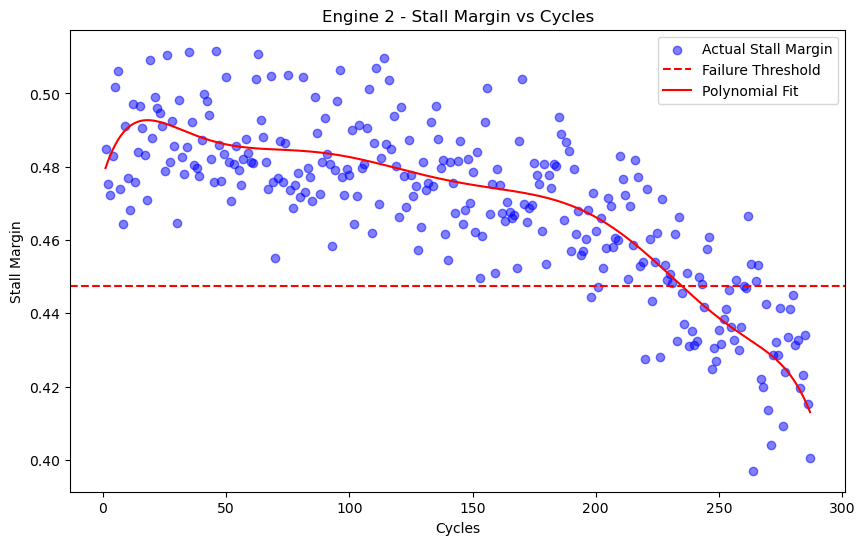

r2 score is:0.6870203506749116
Stall margin breaches the threshold at cycle 153, predicted value 0.44707609207734184


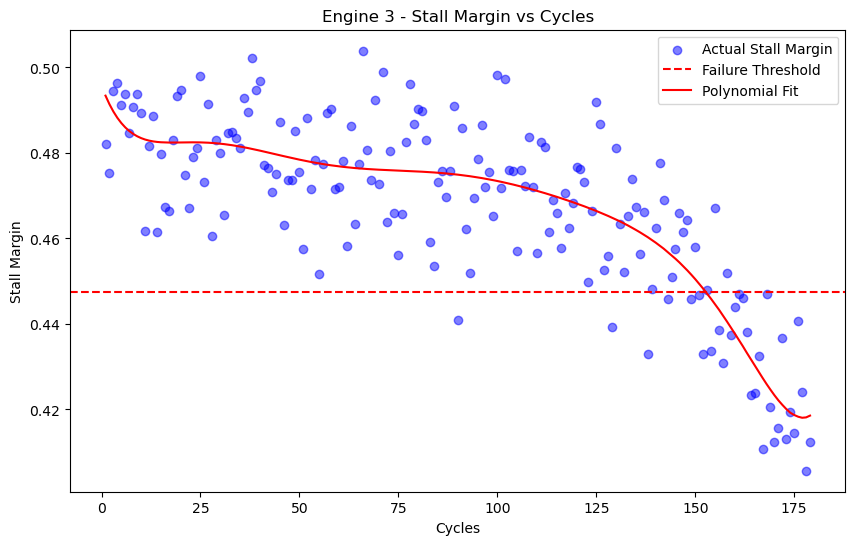

r2 score is:0.6516690703518417
Stall margin breaches the threshold at cycle 163, predicted value 0.4471915280723411


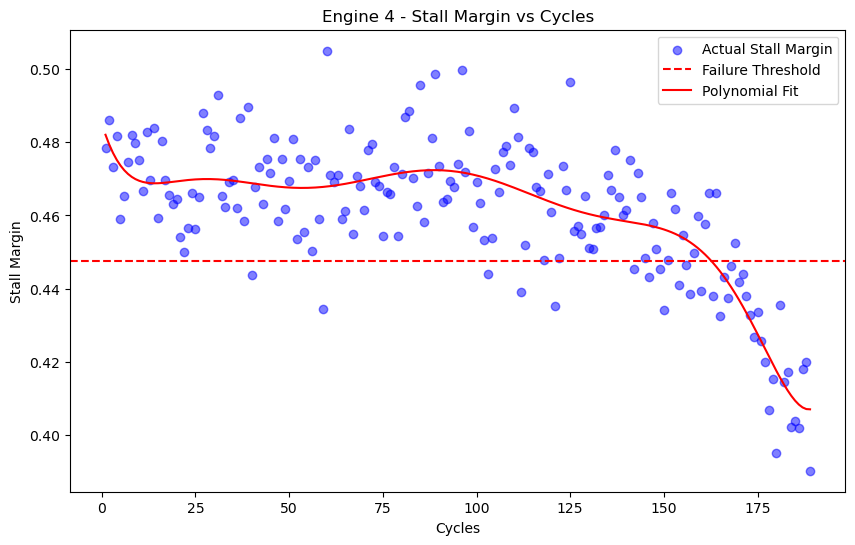

r2 score is:0.7029964632590838
Stall margin breaches the threshold at cycle 223, predicted value 0.4474772505811432


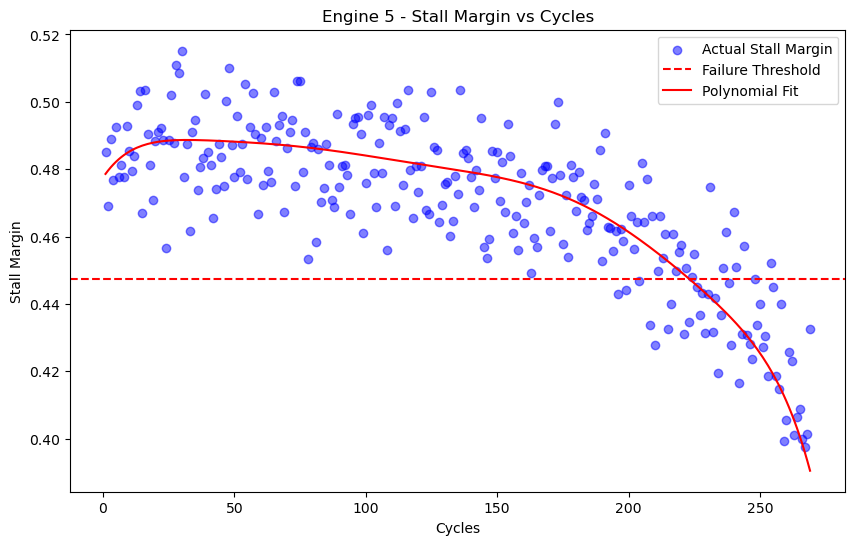

r2 score is:0.5404246167497407
Stall margin breaches the threshold at cycle 140, predicted value 0.4472149763650411


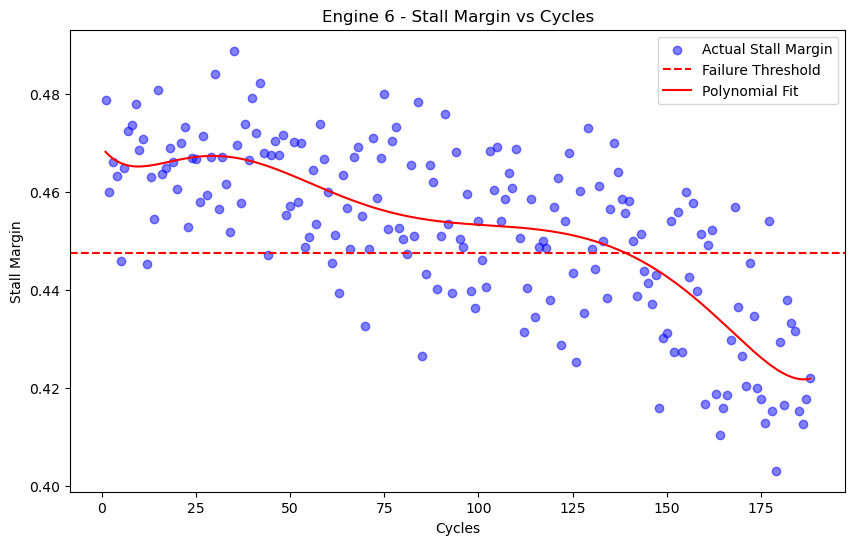

r2 score is:0.6480558645774256
Stall margin breaches the threshold at cycle 213, predicted value 0.44731503607929485


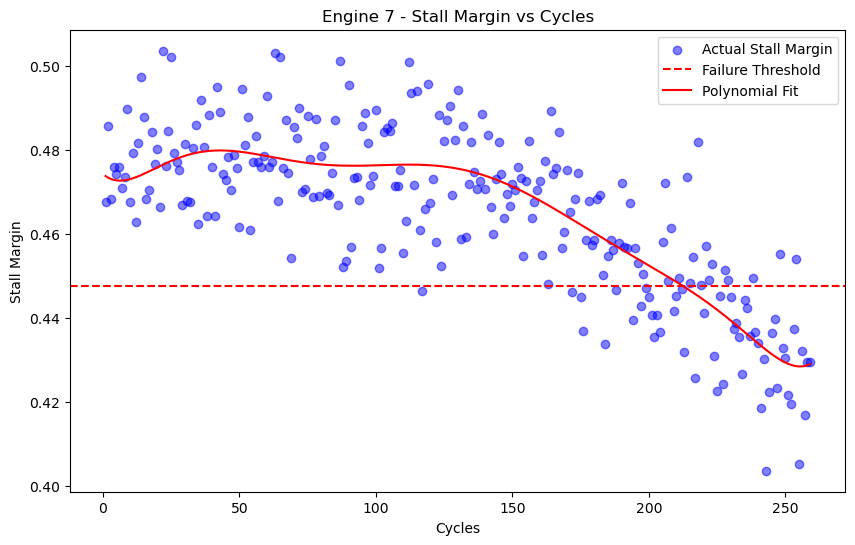

r2 score is:0.4899744657551478
Stall margin breaches the threshold at cycle 103, predicted value 0.4474882295564429


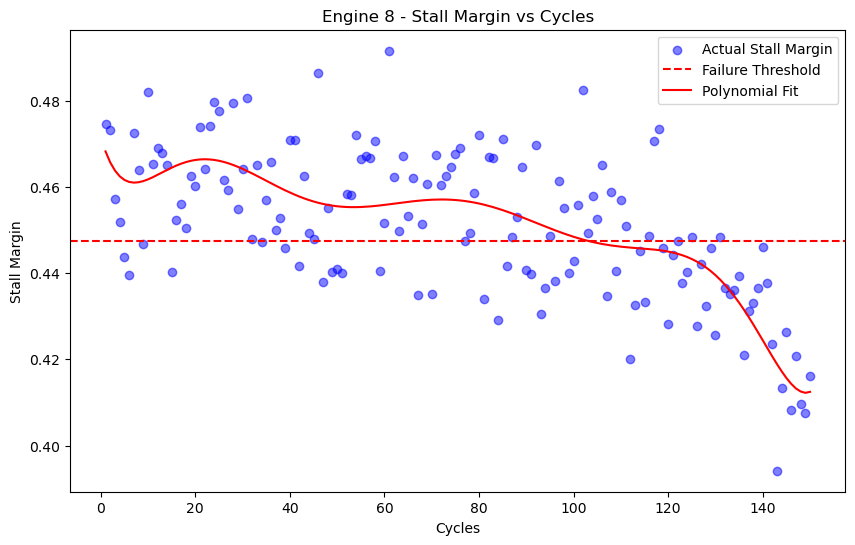

r2 score is:0.6320412770034163
Stall margin breaches the threshold at cycle 177, predicted value 0.4464867837843991


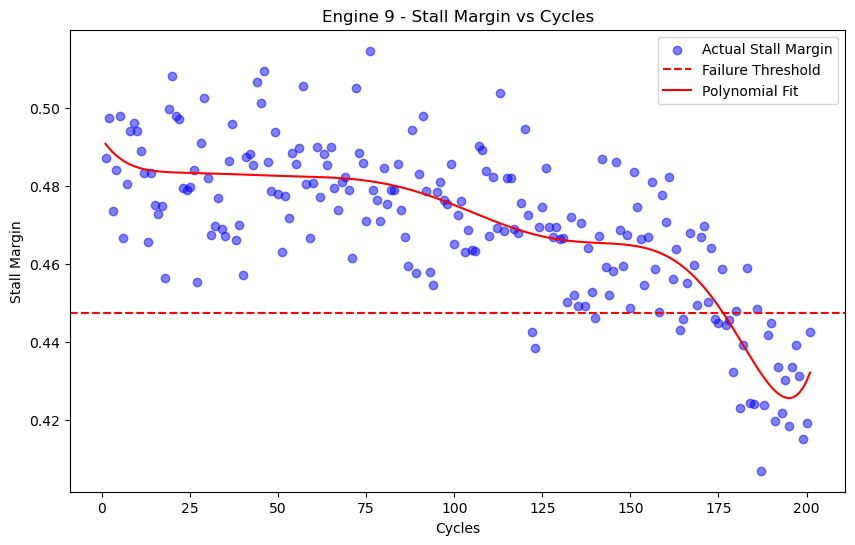

r2 score is:0.6277403753959176
Stall margin breaches the threshold at cycle 196, predicted value 0.4474652613662203


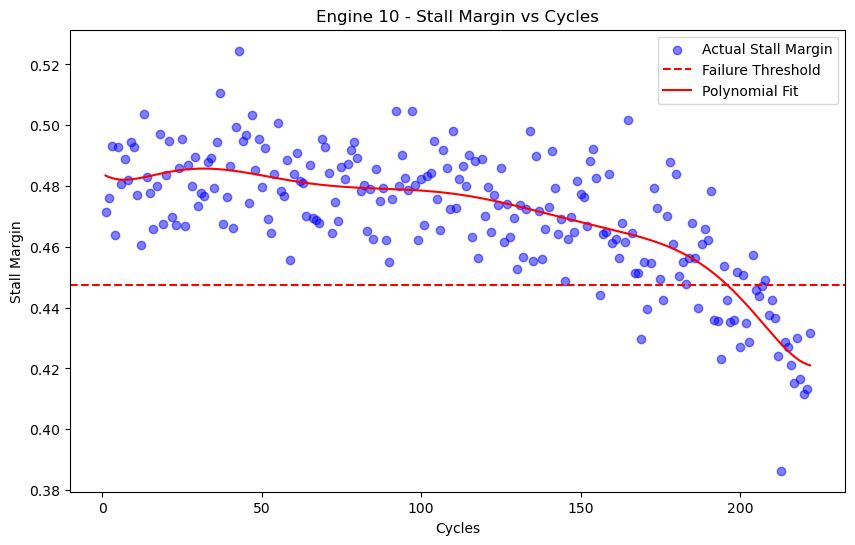

r2 score is:0.6723458967923739
Stall margin breaches the threshold at cycle 202, predicted value 0.44701009863507957


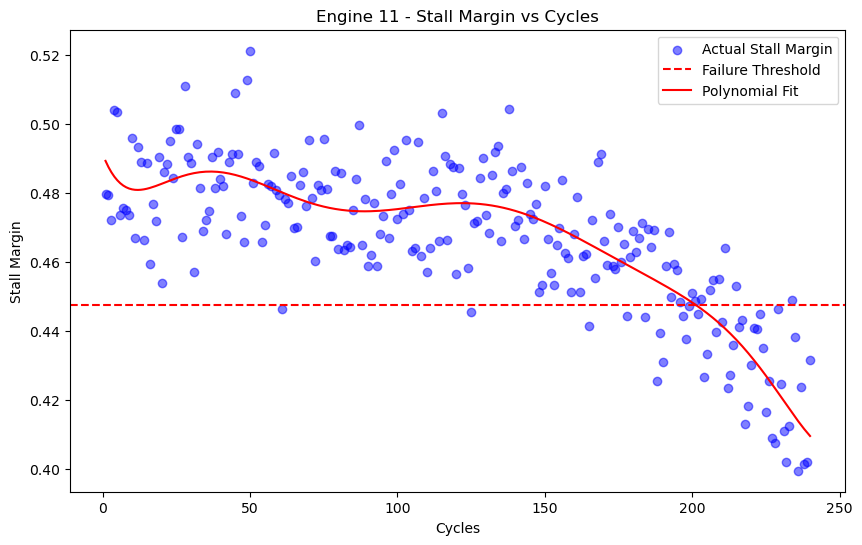

r2 score is:0.4091402138610225
Stall margin breaches the threshold at cycle 127, predicted value 0.44741533952087725


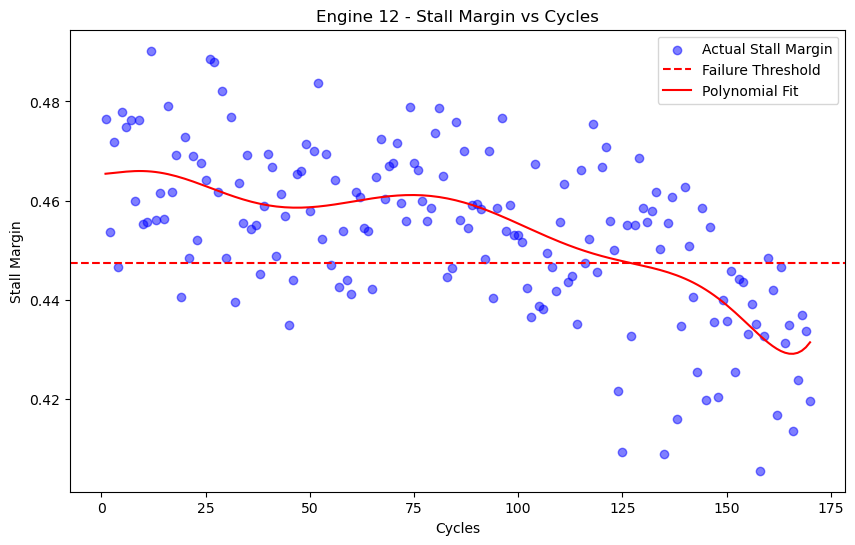

r2 score is:0.5828760858582822
Stall margin breaches the threshold at cycle 132, predicted value 0.4472225529805977


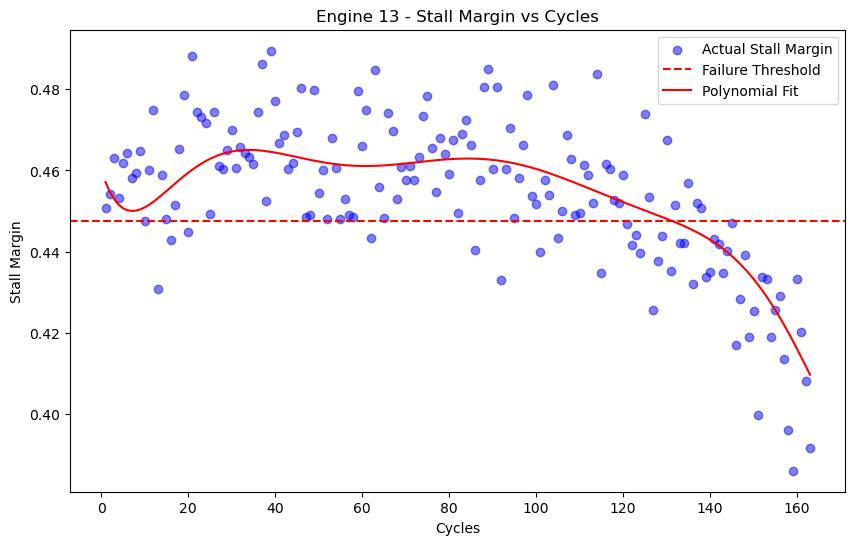

r2 score is:0.6067101373236987
Stall margin breaches the threshold at cycle 116, predicted value 0.4473553161434261


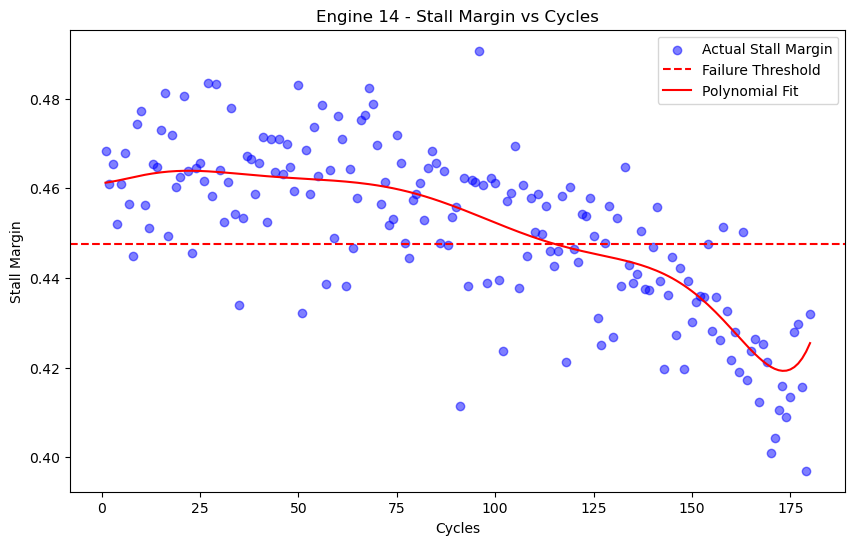

r2 score is:0.6765310589403521
Stall margin breaches the threshold at cycle 176, predicted value 0.44701700172963116


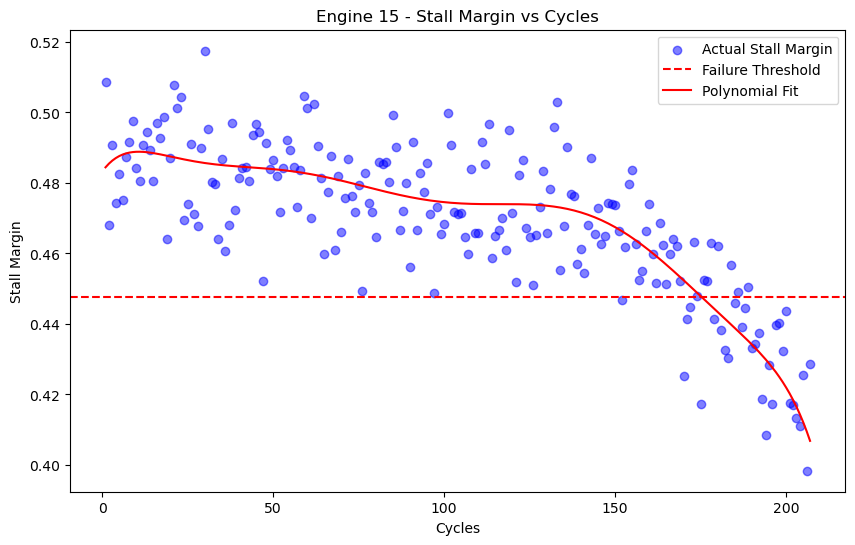

r2 score is:0.41766063733393244
Stall margin breaches the threshold at cycle 137, predicted value 0.4473809154945003


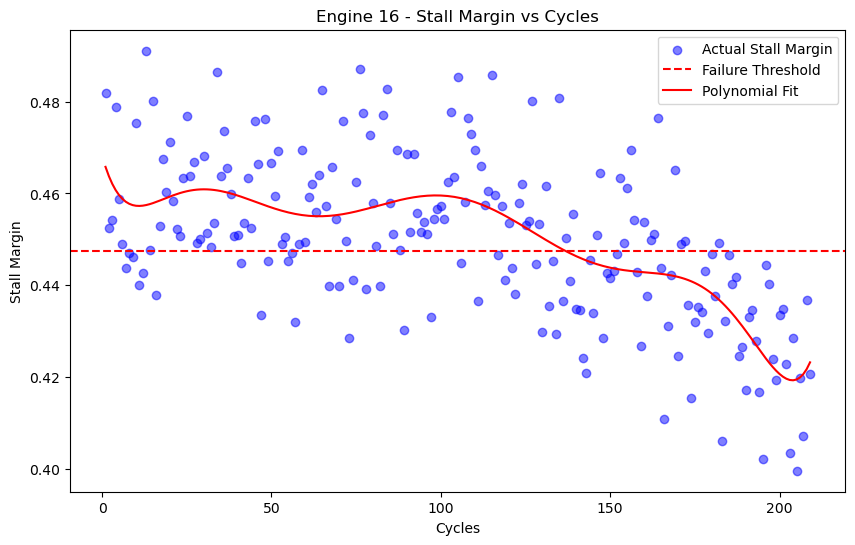

r2 score is:0.6530291122484437
Stall margin breaches the threshold at cycle 238, predicted value 0.44718058733858096


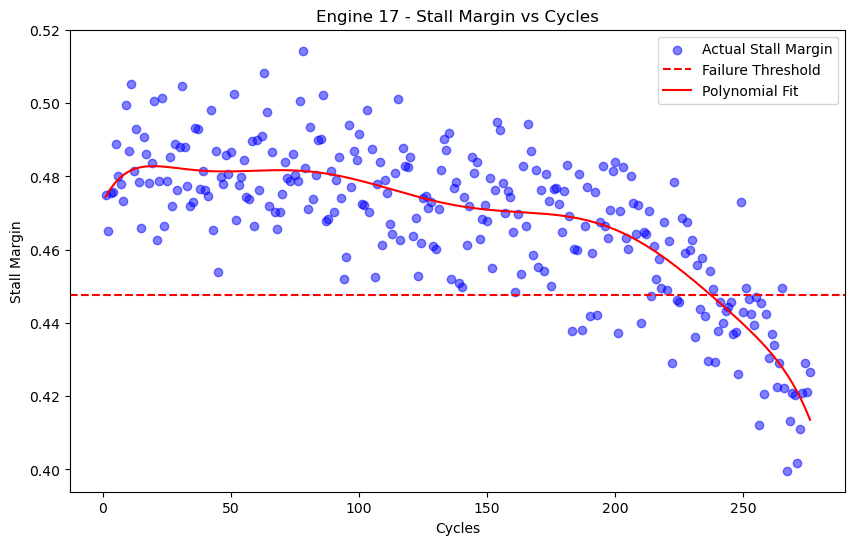

r2 score is:0.6982387644266517
Stall margin breaches the threshold at cycle 169, predicted value 0.4474399577017144


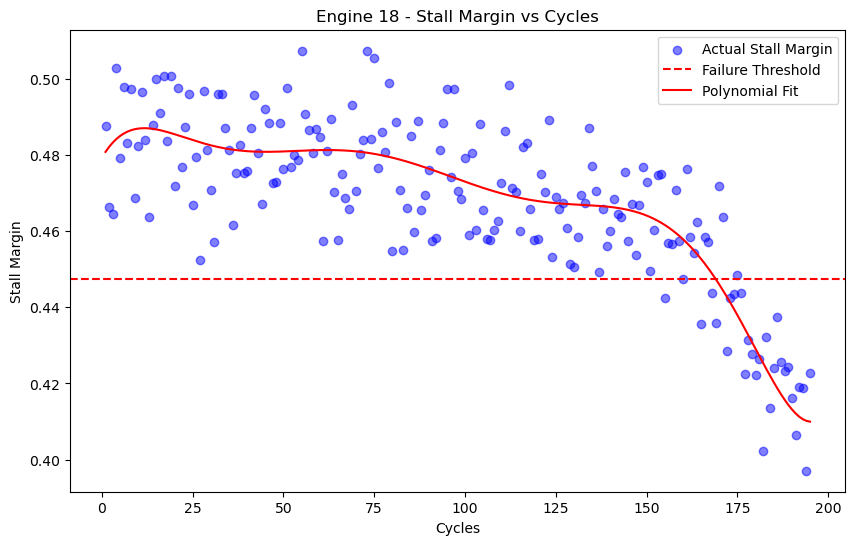

r2 score is:0.5012745862667165
Stall margin breaches the threshold at cycle 94, predicted value 0.4471160802350558


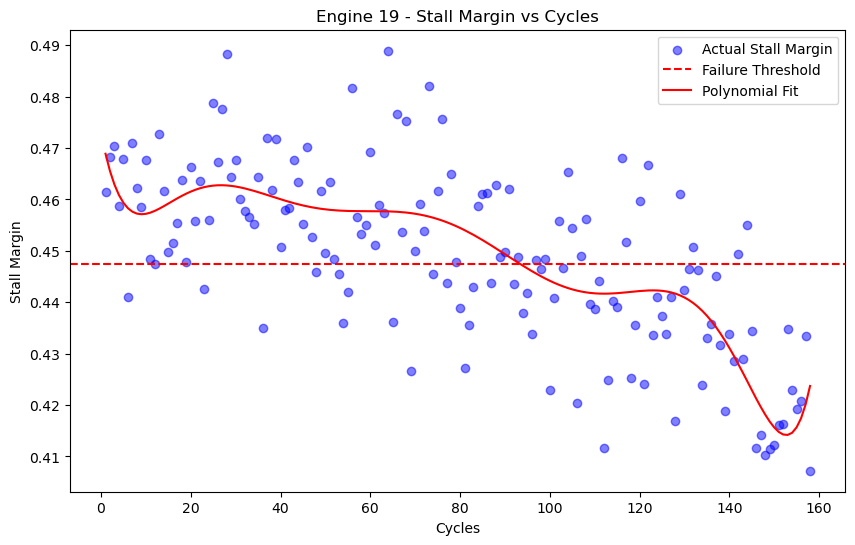

r2 score is:0.5422063335830438
Stall margin breaches the threshold at cycle 161, predicted value 0.4472676304262653


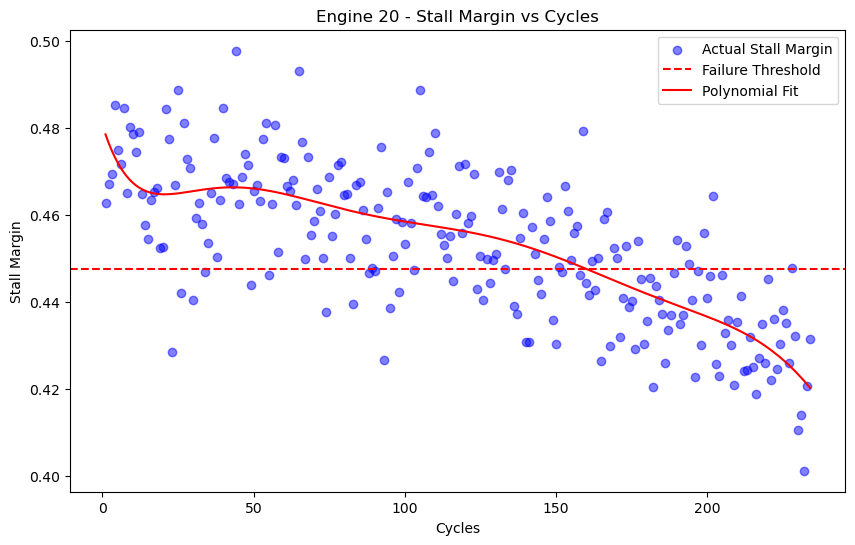

r2 score is:0.46202422152892597
Stall margin breaches the threshold at cycle 157, predicted value 0.4473038177497031


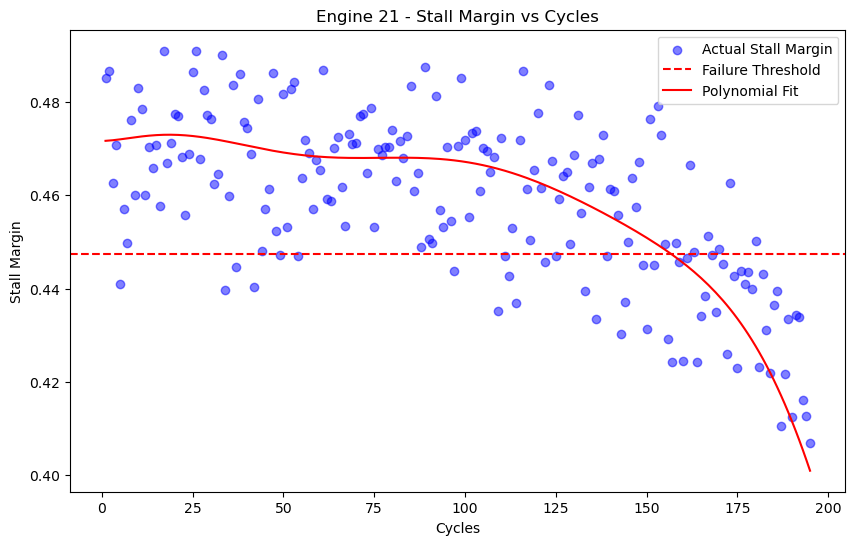

r2 score is:0.46364382992589814
Stall margin breaches the threshold at cycle 129, predicted value 0.4473128094188817


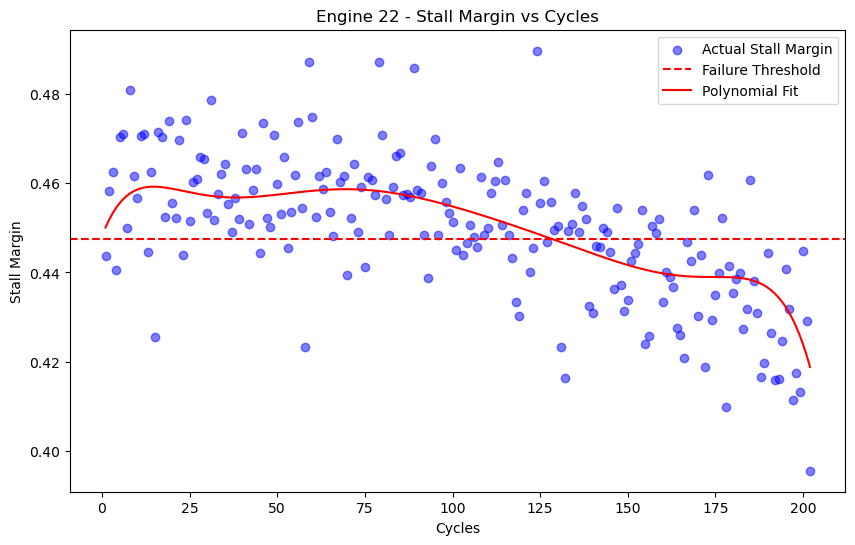

r2 score is:0.5393101295809963
Stall margin breaches the threshold at cycle 123, predicted value 0.4472149647391742


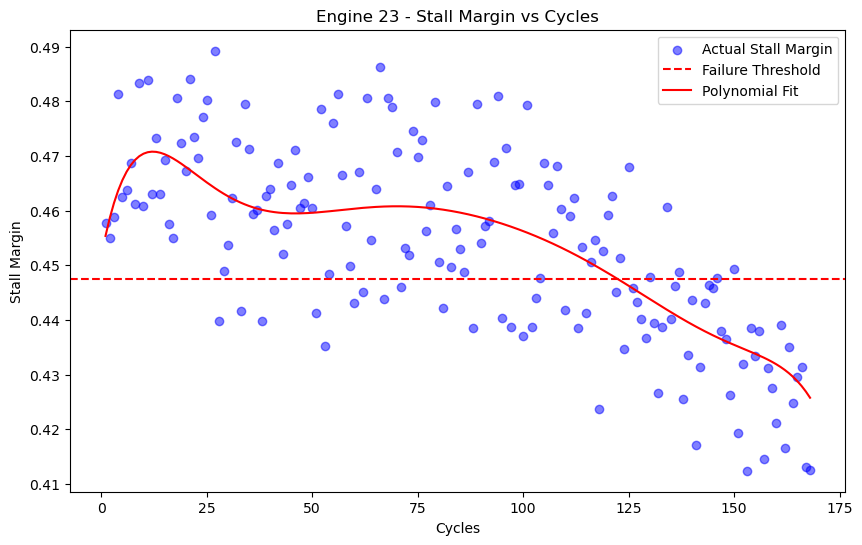

r2 score is:0.687543426451414
Stall margin breaches the threshold at cycle 125, predicted value 0.4466000826756468


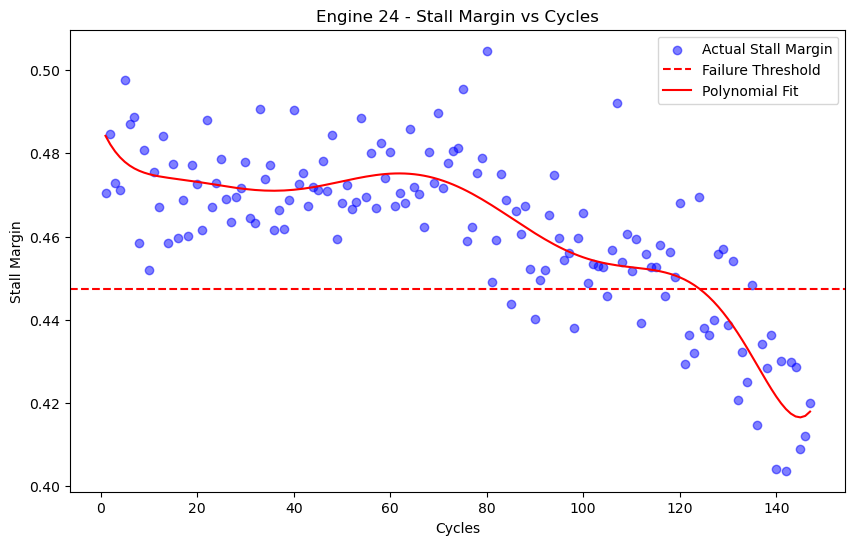

r2 score is:0.550981175813466
Stall margin breaches the threshold at cycle 179, predicted value 0.44749269201316844


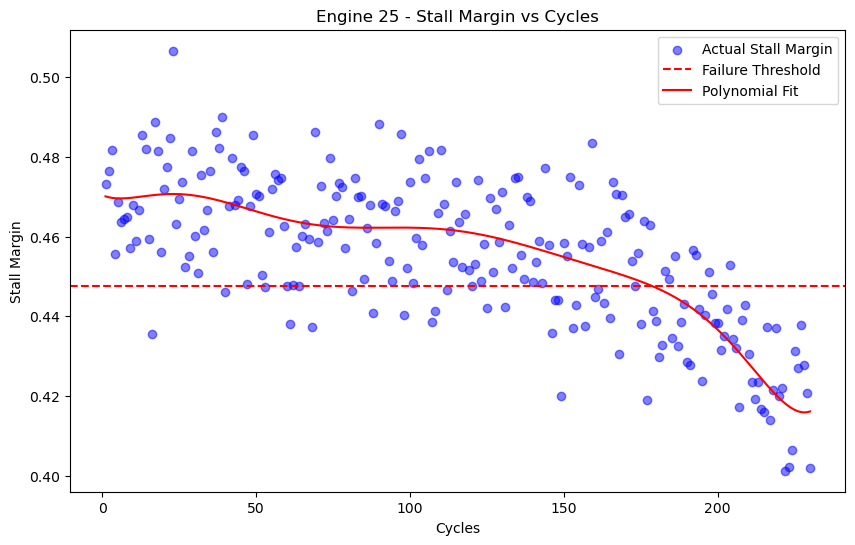

r2 score is:0.5050796006231151
Stall margin breaches the threshold at cycle 152, predicted value 0.4473936192195221


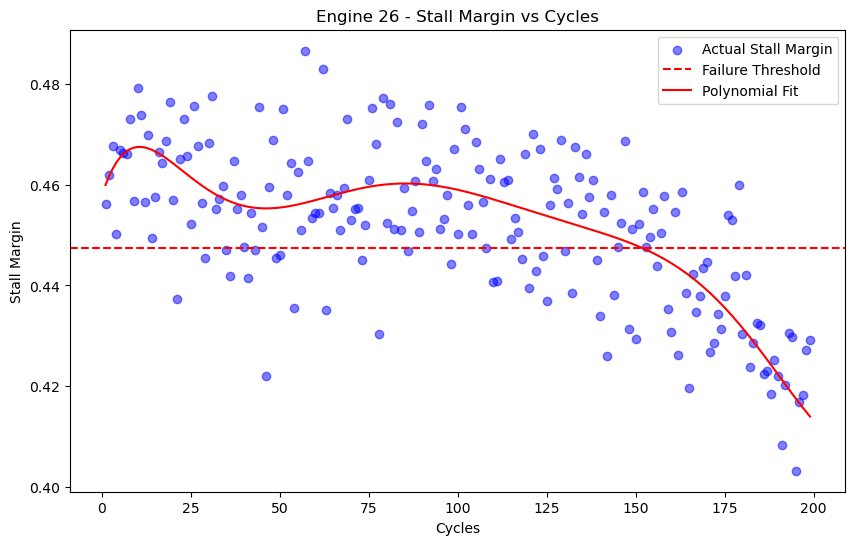

r2 score is:0.5812063408407254
Stall margin breaches the threshold at cycle 121, predicted value 0.44726586127964796


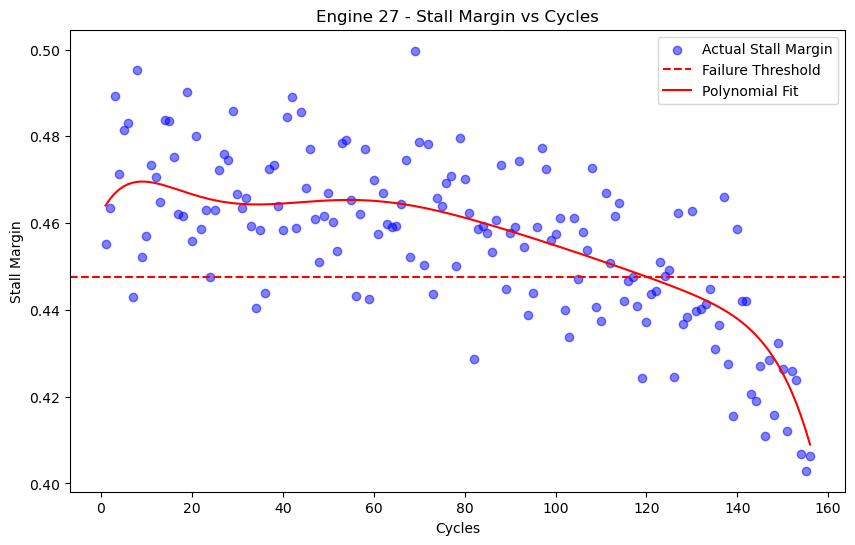

r2 score is:0.5971076678522975
Stall margin breaches the threshold at cycle 152, predicted value 0.44689985932903165


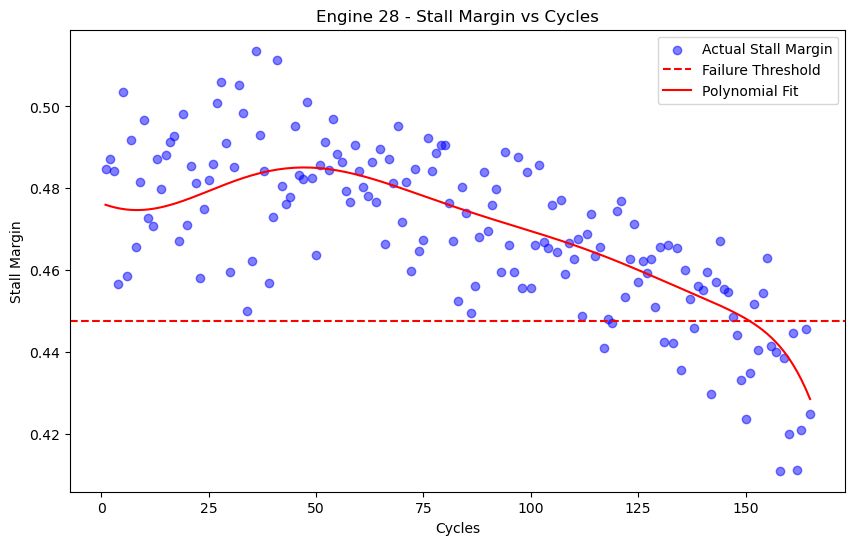

r2 score is:0.527908600742155
Stall margin breaches the threshold at cycle 130, predicted value 0.44732967471131996


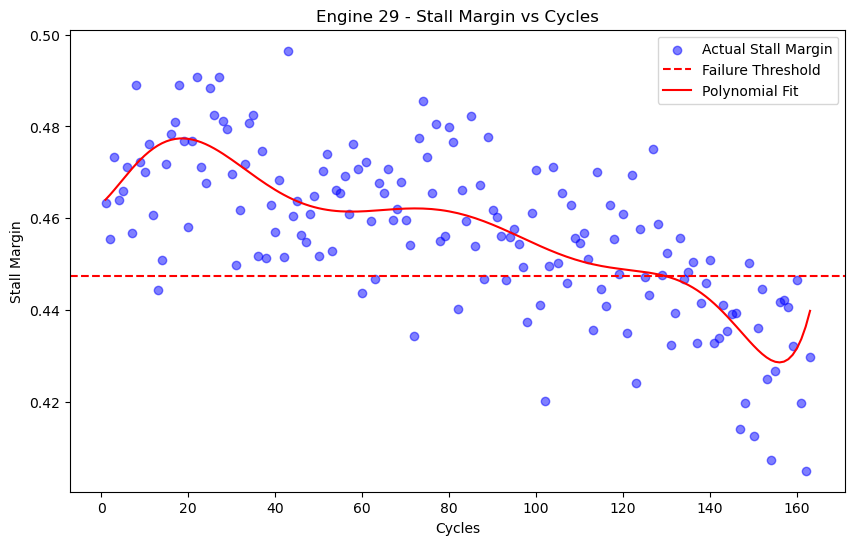

r2 score is:0.6849236568881416
Stall margin breaches the threshold at cycle 171, predicted value 0.44706123536813974


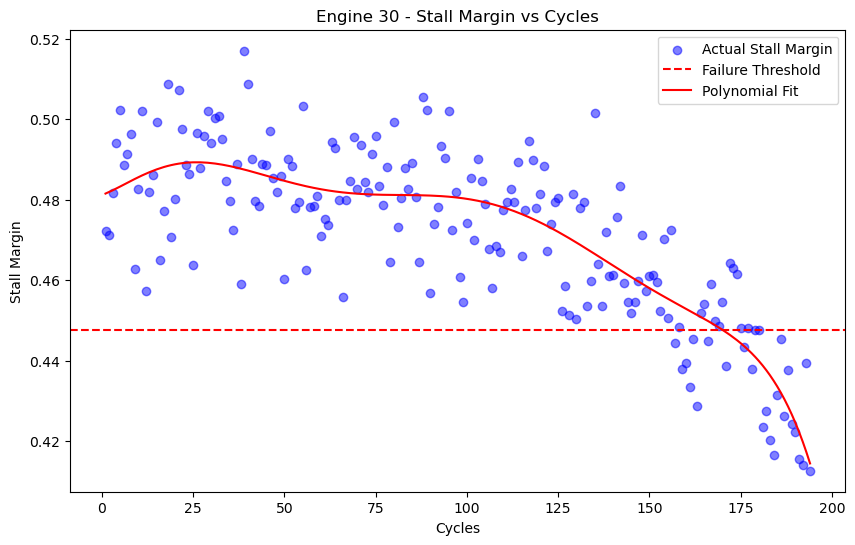

r2 score is:0.6698358113782923
Stall margin breaches the threshold at cycle 204, predicted value 0.4467458139993371


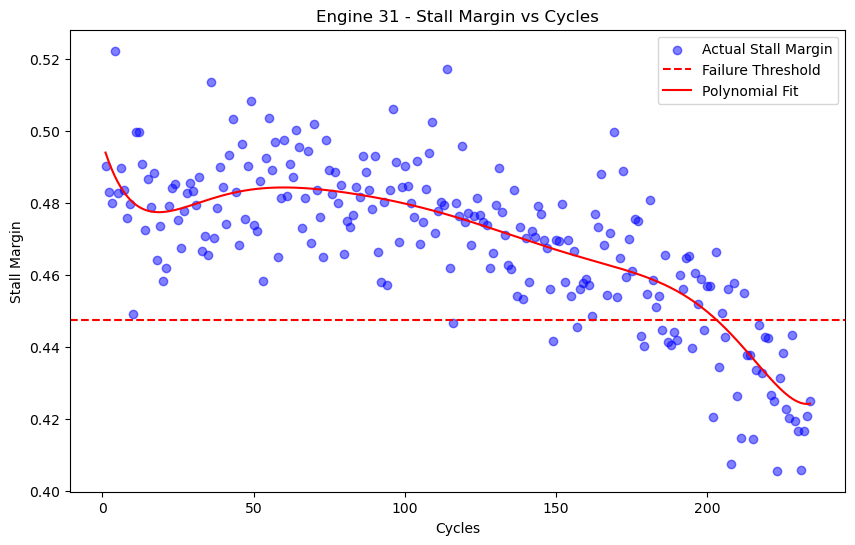

r2 score is:0.510877622327305
Stall margin breaches the threshold at cycle 136, predicted value 0.44731512906952137


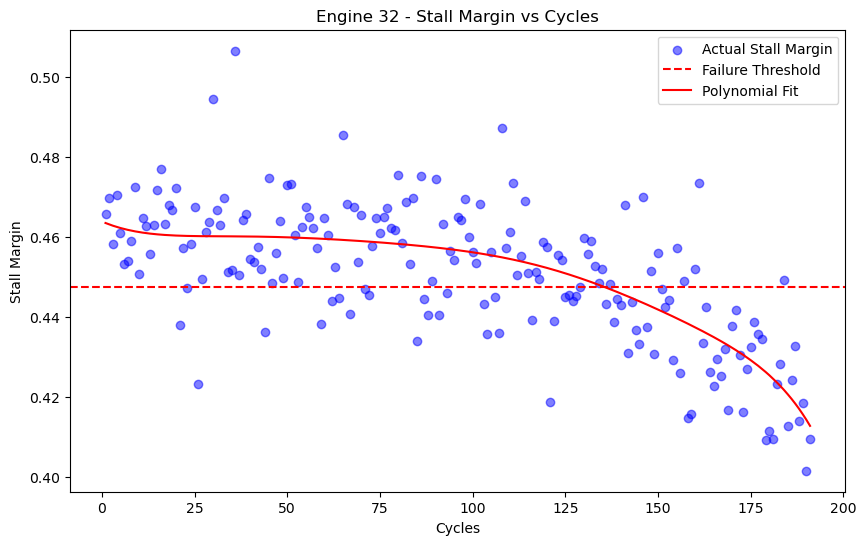

r2 score is:0.6572135797753516
Stall margin breaches the threshold at cycle 168, predicted value 0.44719804267965235


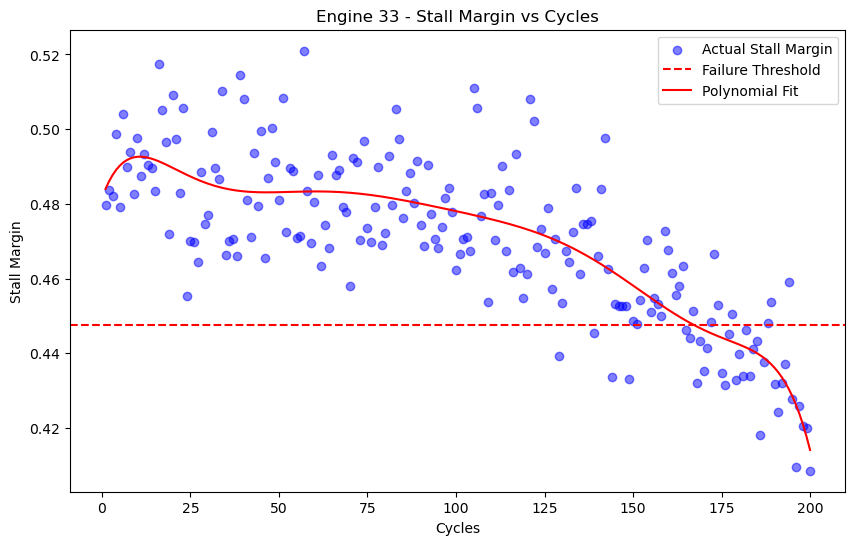

r2 score is:0.44878230036158007
Stall margin breaches the threshold at cycle 158, predicted value 0.44695826694838064


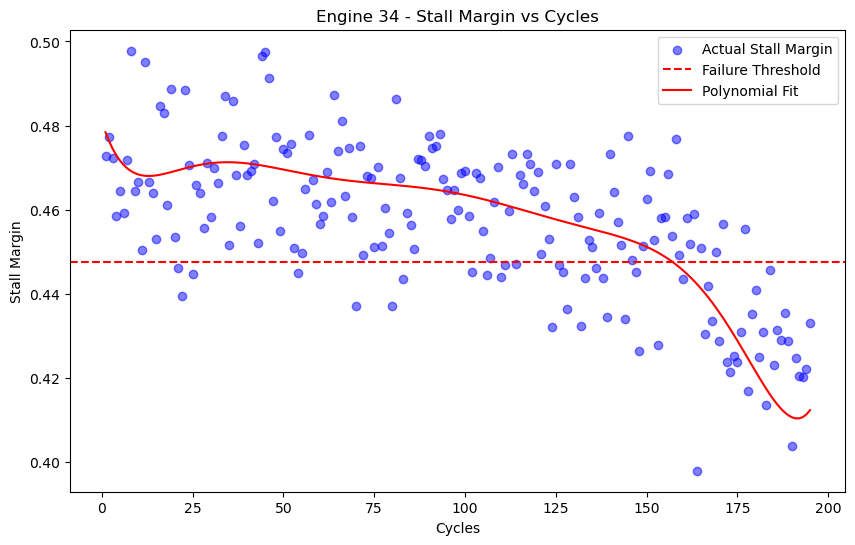

r2 score is:0.6644741660861182
Stall margin breaches the threshold at cycle 139, predicted value 0.44689479537432397


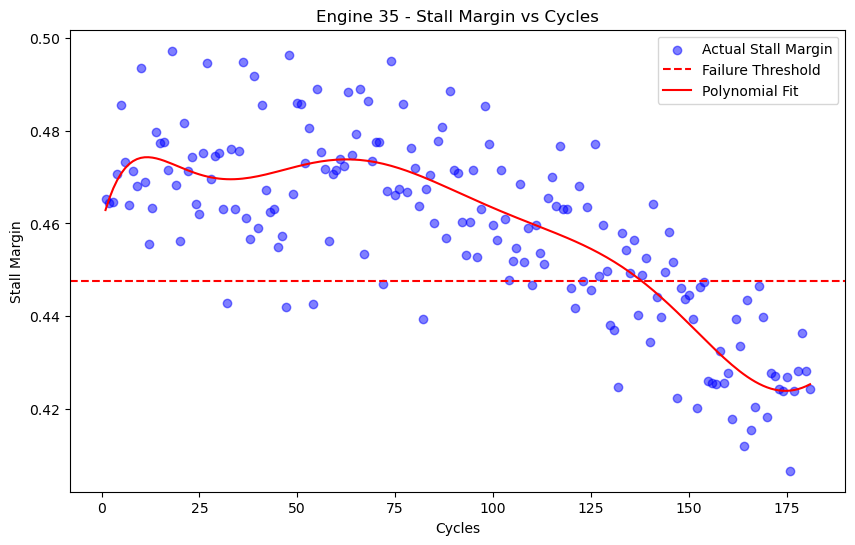

r2 score is:0.4220428260419622
Stall margin breaches the threshold at cycle 118, predicted value 0.44737885749529


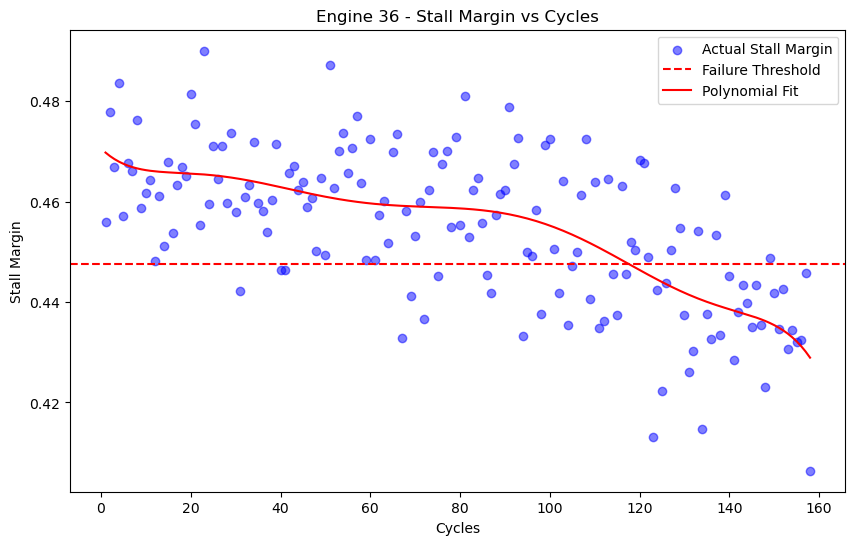

r2 score is:0.48738862506919944
Stall margin breaches the threshold at cycle 135, predicted value 0.4473133923982545


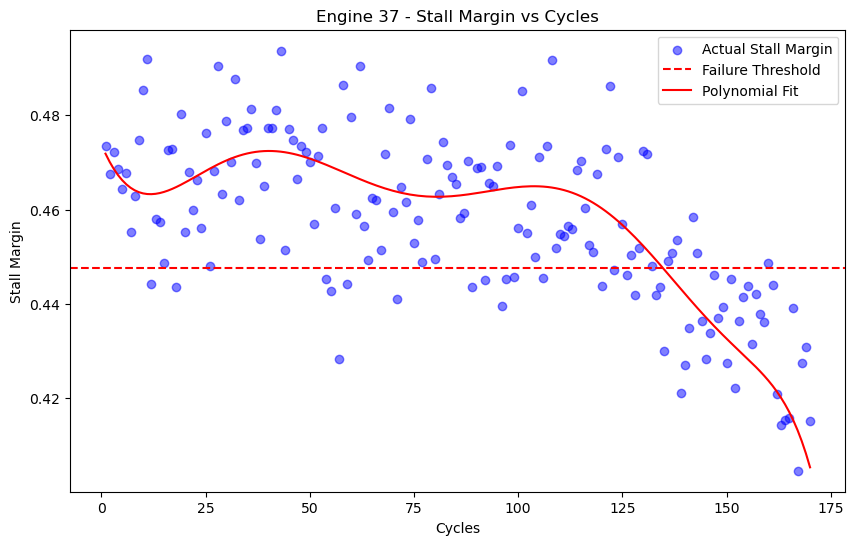

r2 score is:0.48862381929932963
Stall margin breaches the threshold at cycle 140, predicted value 0.4474740046600076


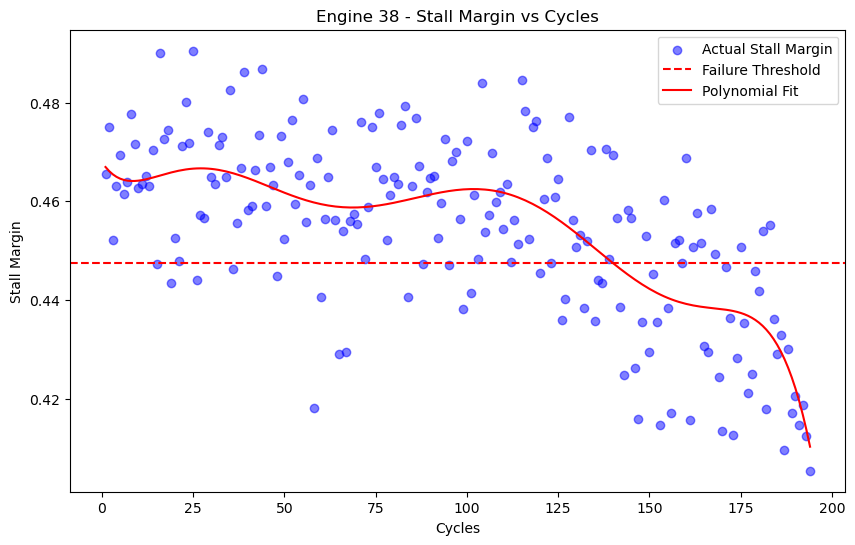

r2 score is:0.47524179109381126
Stall margin breaches the threshold at cycle 94, predicted value 0.44737304151879065


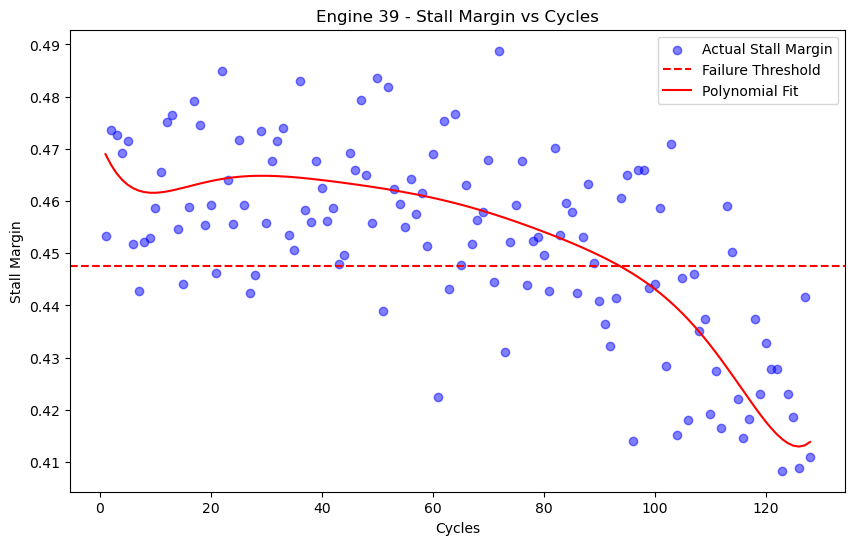

r2 score is:0.6083069113701436
Stall margin breaches the threshold at cycle 125, predicted value 0.4473642996553841


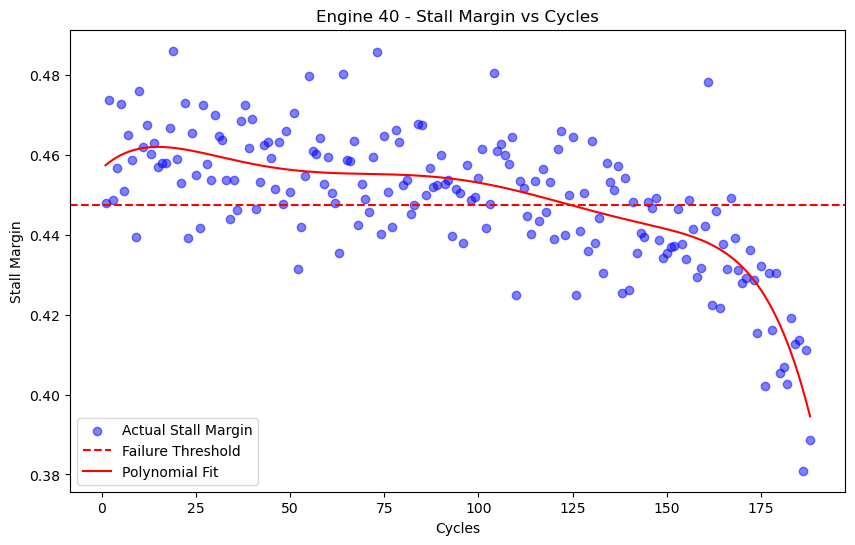

r2 score is:0.6606009523809675
Stall margin breaches the threshold at cycle 183, predicted value 0.44745373998313026


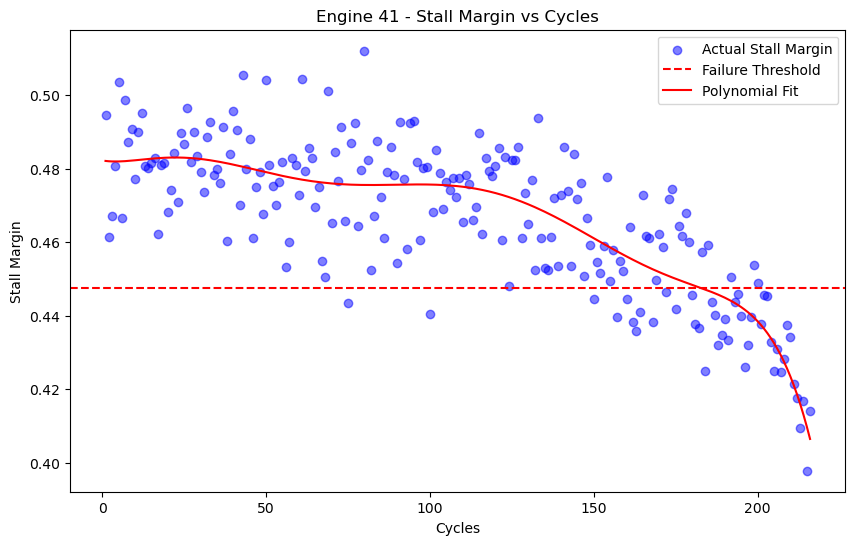

r2 score is:0.5288389840252952
Stall margin breaches the threshold at cycle 159, predicted value 0.4472113646443549


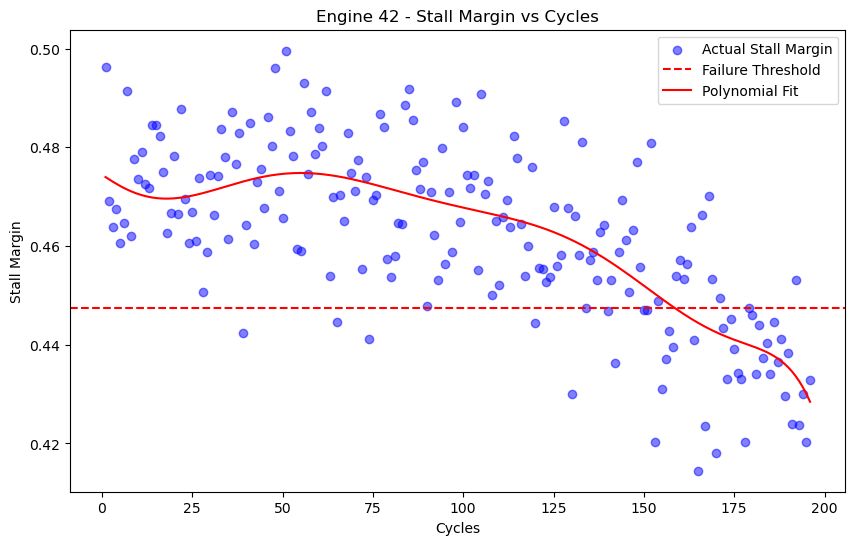

r2 score is:0.6464642618431171
Stall margin breaches the threshold at cycle 172, predicted value 0.44723760903128384


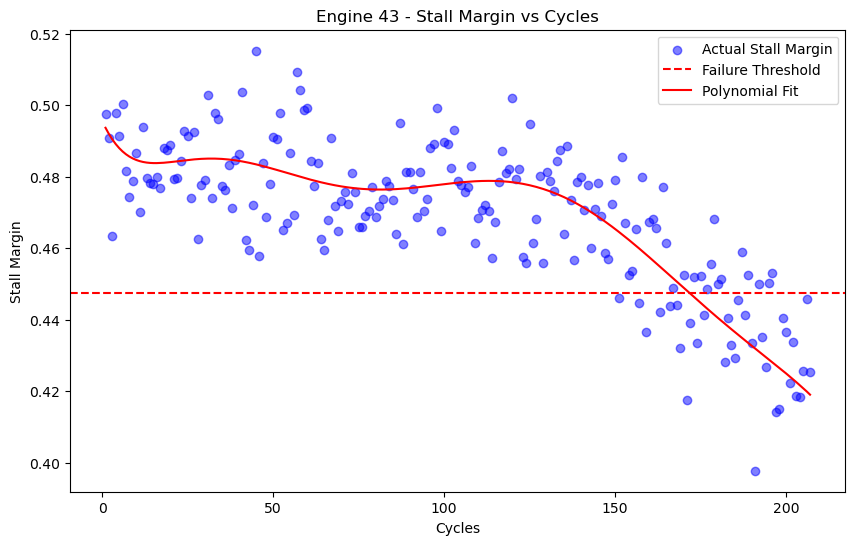

r2 score is:0.6487665668417232
Stall margin breaches the threshold at cycle 160, predicted value 0.4471008931371839


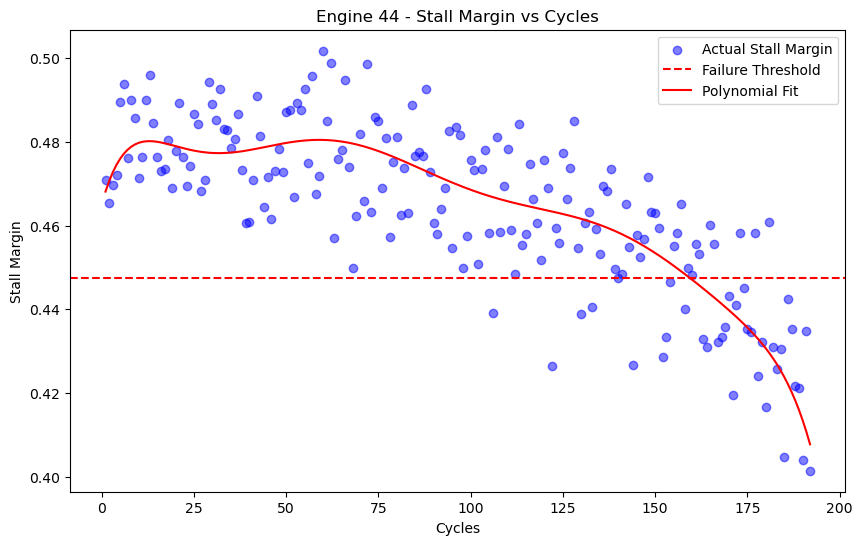

r2 score is:0.7059350611948305
Stall margin breaches the threshold at cycle 134, predicted value 0.44721589183532817


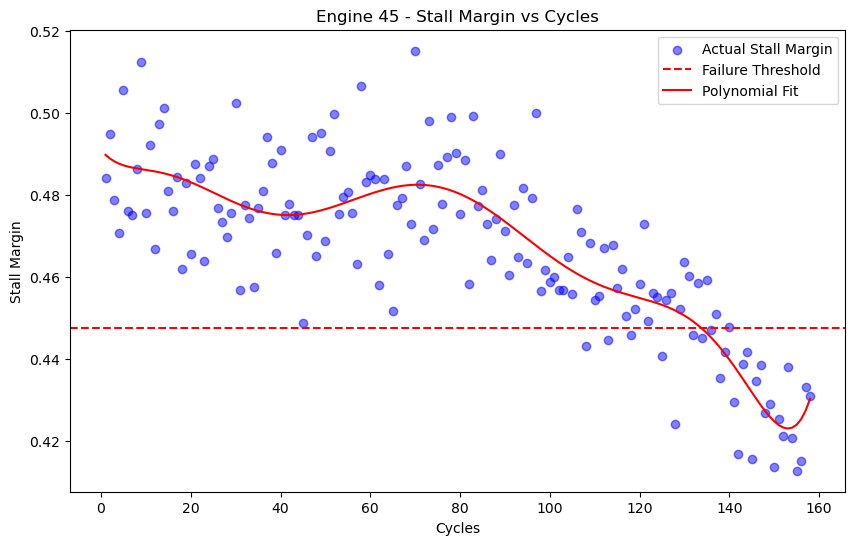

r2 score is:0.6139858751898559
Stall margin breaches the threshold at cycle 226, predicted value 0.44696338985862816


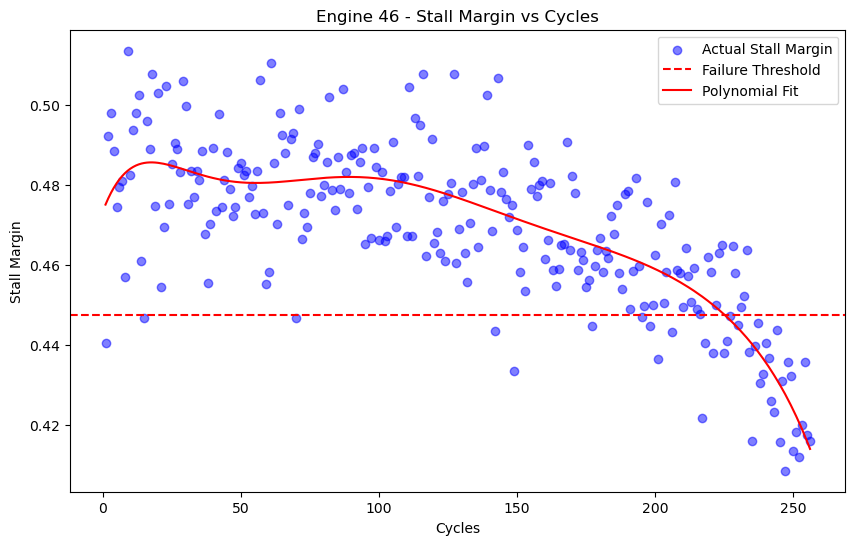

r2 score is:0.7114888016873586
Stall margin breaches the threshold at cycle 180, predicted value 0.44717182344640594


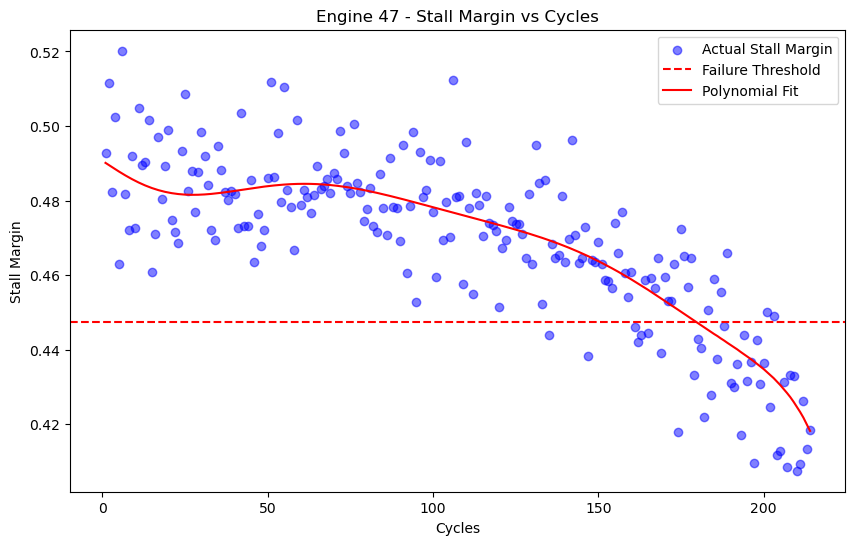

r2 score is:0.6324702823783273
Stall margin breaches the threshold at cycle 202, predicted value 0.44715164217447656


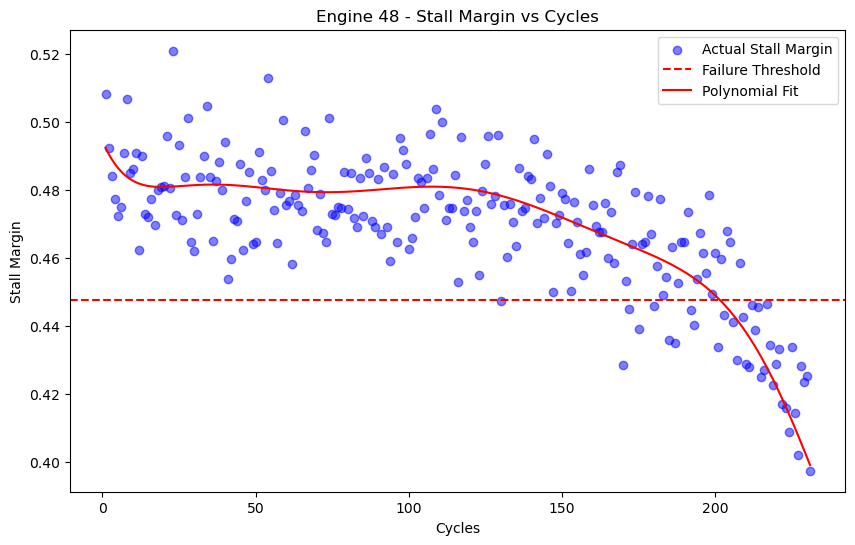

r2 score is:0.4400669017495028
Stall margin breaches the threshold at cycle 162, predicted value 0.44745713491922423


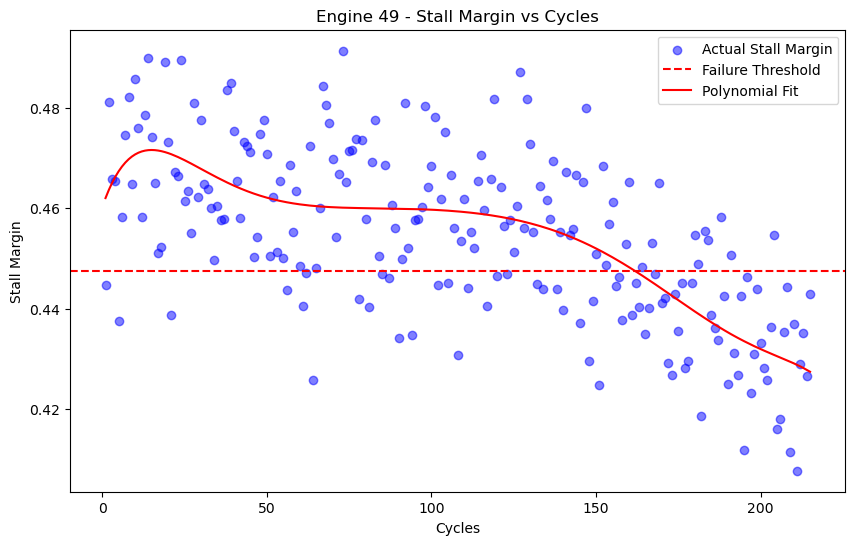

r2 score is:0.6500273424989396
Stall margin breaches the threshold at cycle 160, predicted value 0.4472906718621018


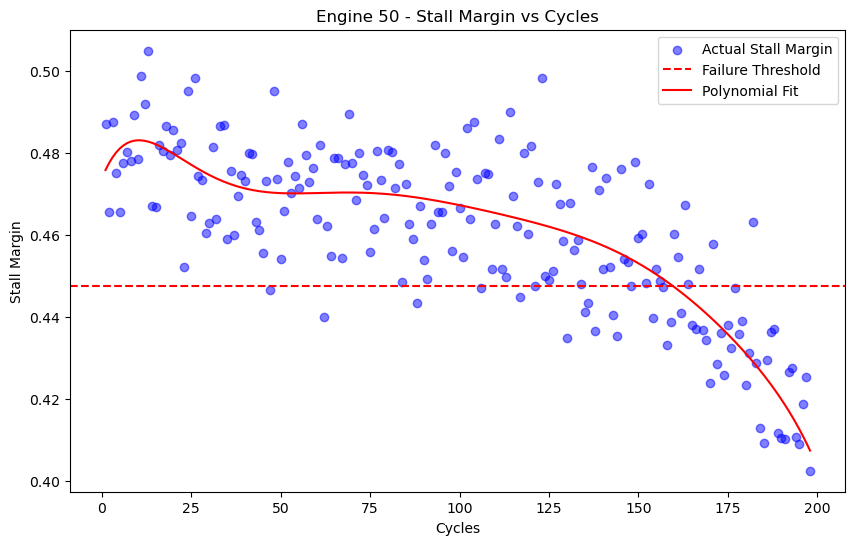

r2 score is:0.6434677547901971
Stall margin breaches the threshold at cycle 190, predicted value 0.44711784587727804


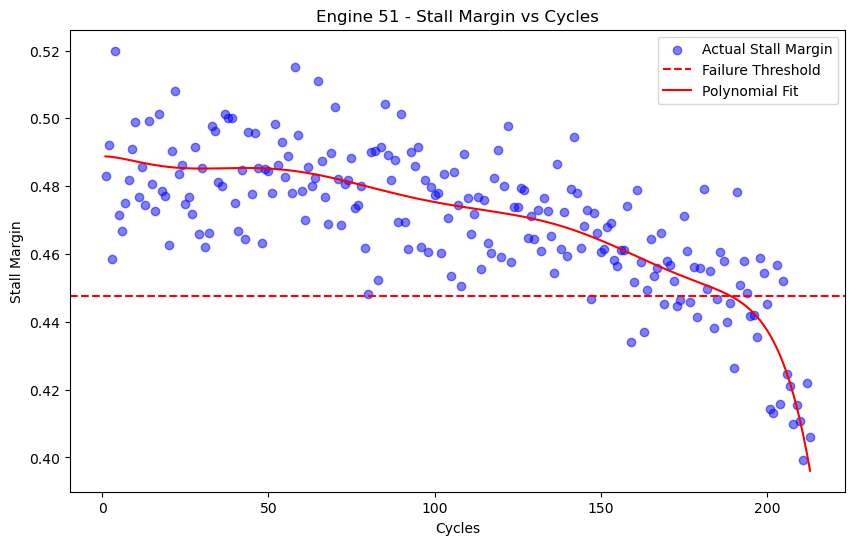

r2 score is:0.596001457957531
Stall margin breaches the threshold at cycle 156, predicted value 0.4471875074818718


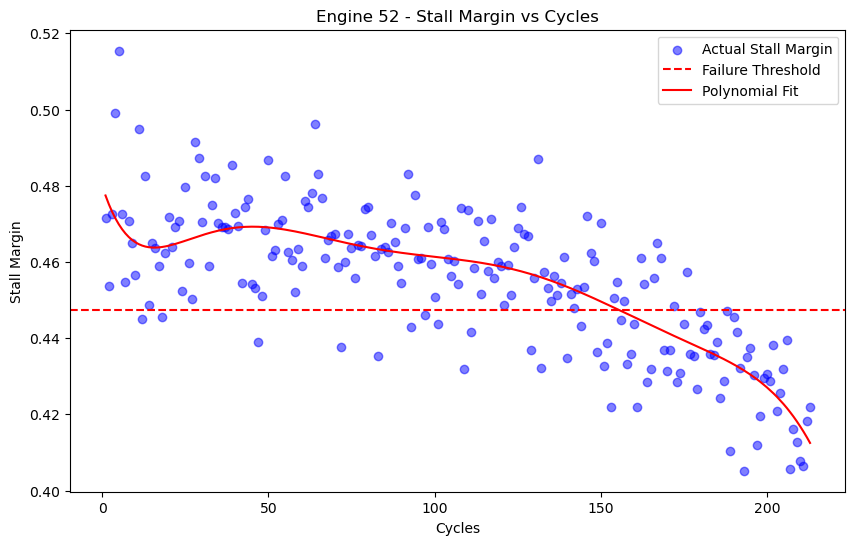

r2 score is:0.651487440843542
Stall margin breaches the threshold at cycle 160, predicted value 0.4471389991163241


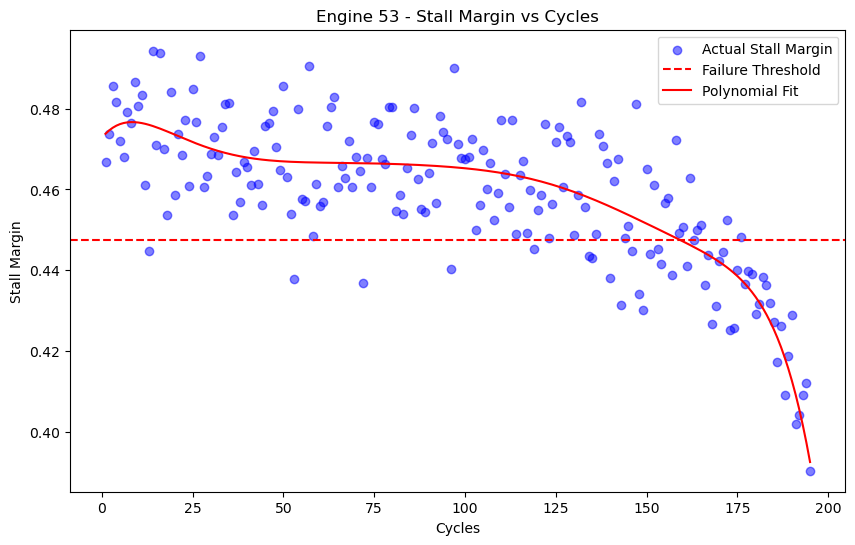

r2 score is:0.6667773296595205
Stall margin breaches the threshold at cycle 208, predicted value 0.44728710277903583


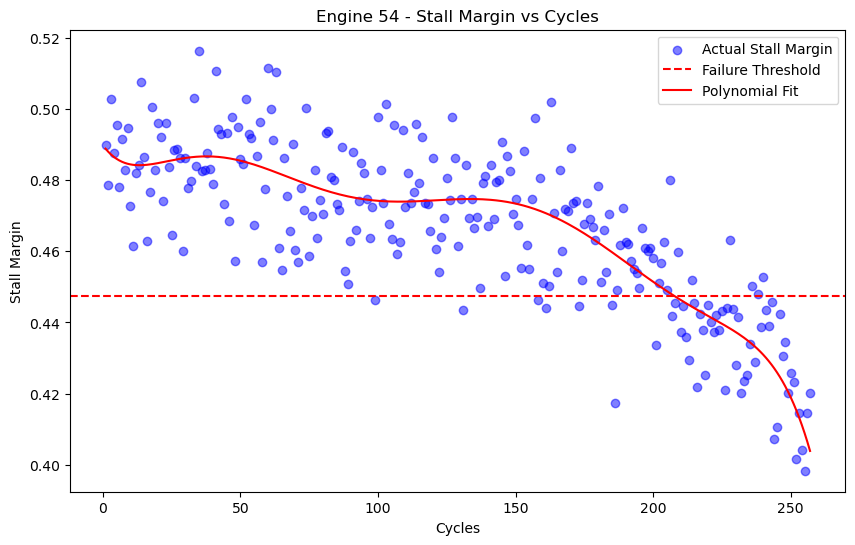

r2 score is:0.5426172211298634
Stall margin breaches the threshold at cycle 161, predicted value 0.4474731608782822


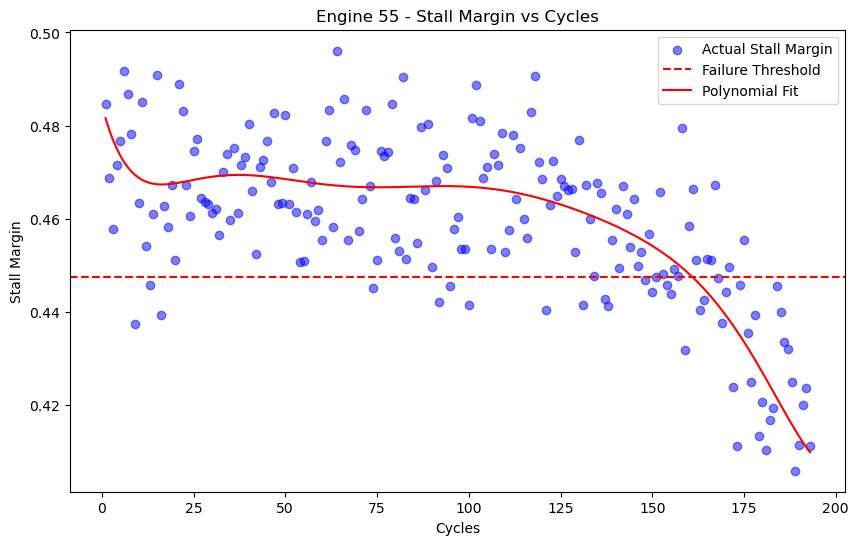

r2 score is:0.43720492876437267
Stall margin breaches the threshold at cycle 209, predicted value 0.44740068508721603


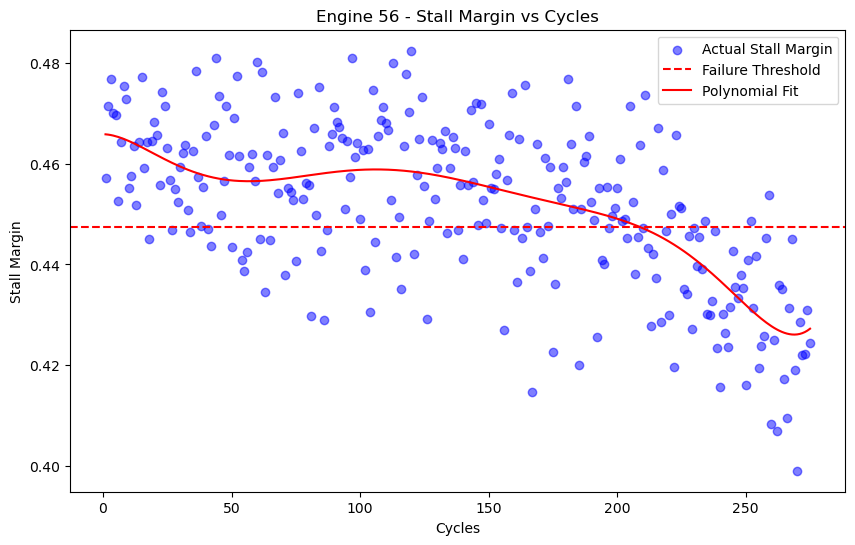

r2 score is:0.6130013355006521
Stall margin breaches the threshold at cycle 112, predicted value 0.4470134794536027


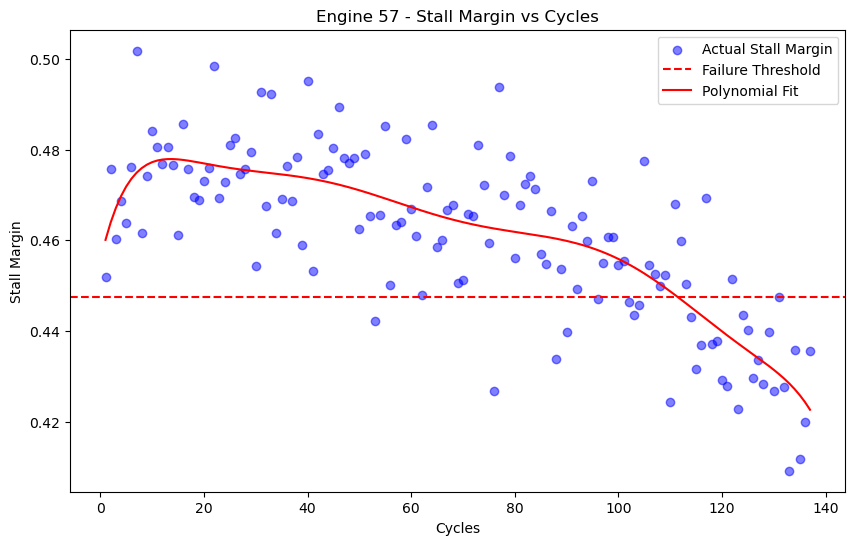

r2 score is:0.546955770120976
Stall margin breaches the threshold at cycle 124, predicted value 0.4470556114405777


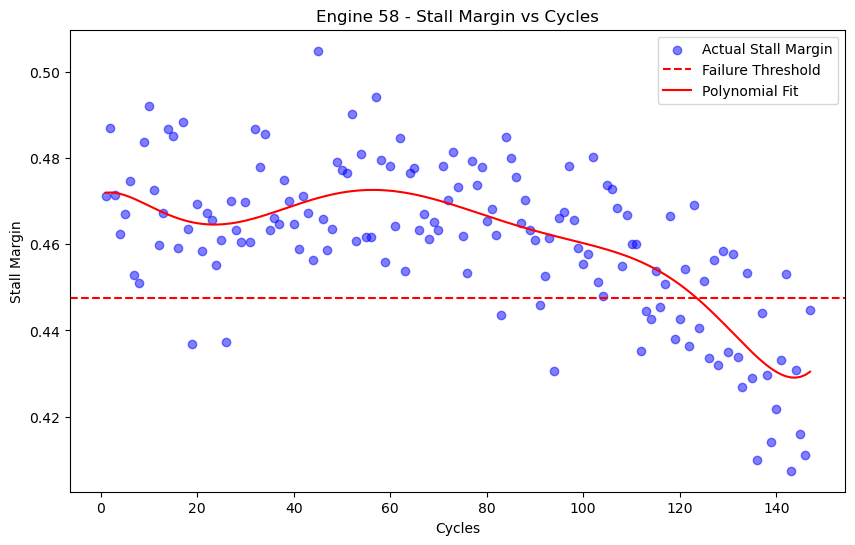

r2 score is:0.6796627121137753
Stall margin breaches the threshold at cycle 193, predicted value 0.44697670509262327


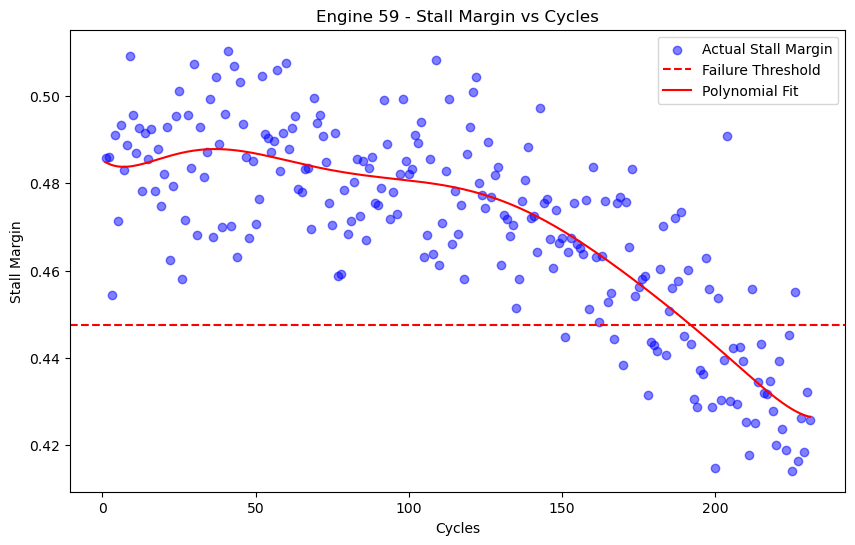

r2 score is:0.6395354124290415
Stall margin breaches the threshold at cycle 134, predicted value 0.44699883818118974


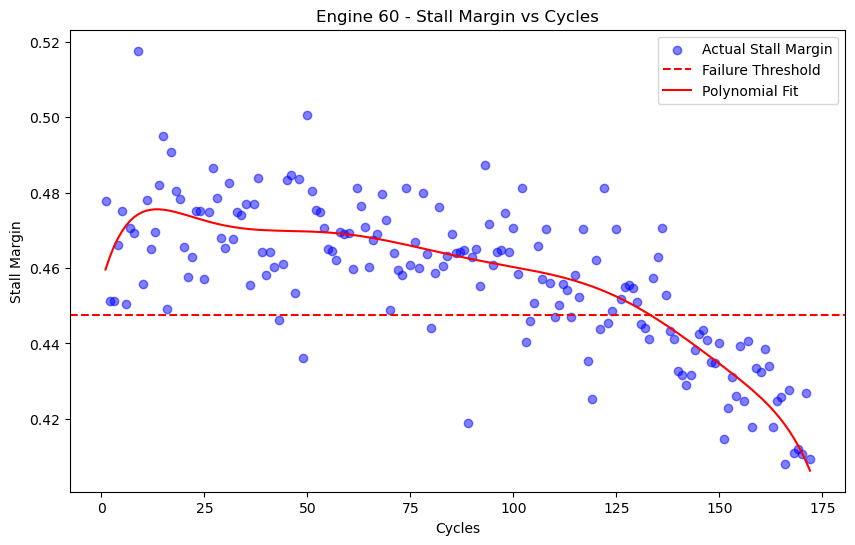

r2 score is:0.6580639543848874
Stall margin breaches the threshold at cycle 161, predicted value 0.44730580704301043


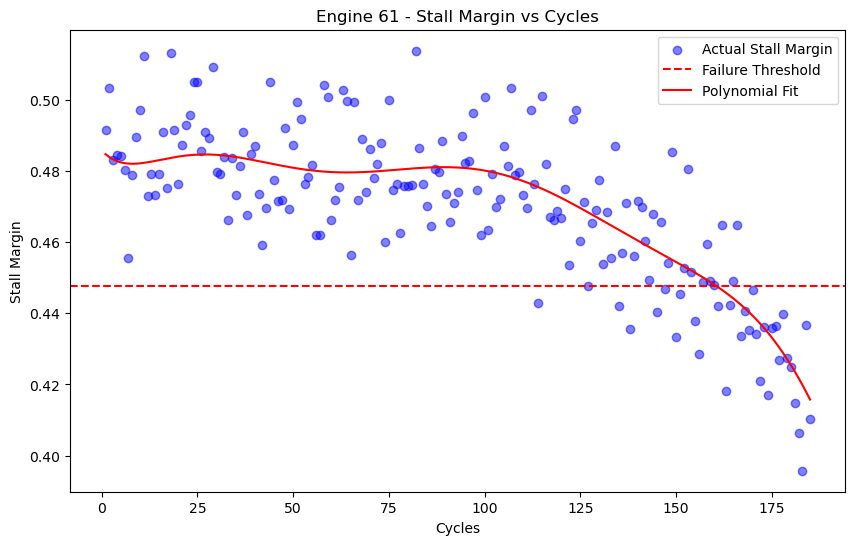

r2 score is:0.38339539012340706
Stall margin breaches the threshold at cycle 131, predicted value 0.4474083833670866


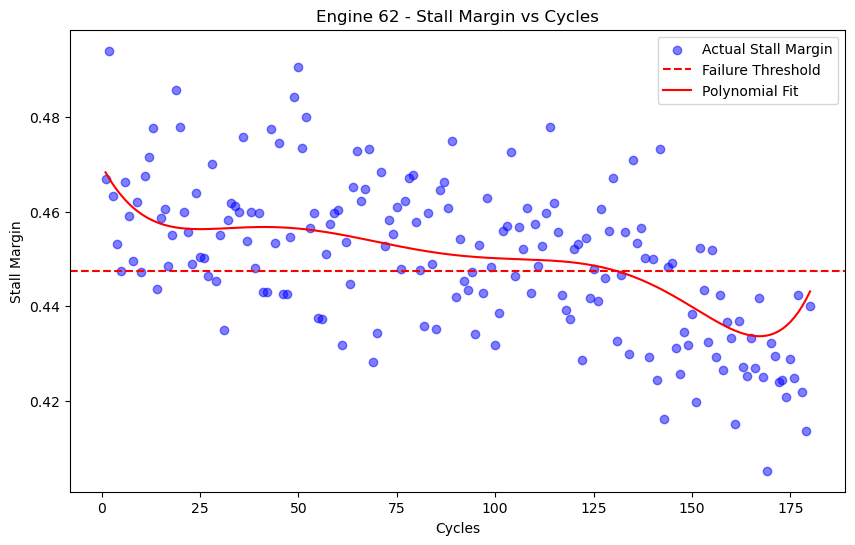

r2 score is:0.5709530823950513
Stall margin breaches the threshold at cycle 135, predicted value 0.44722428299194944


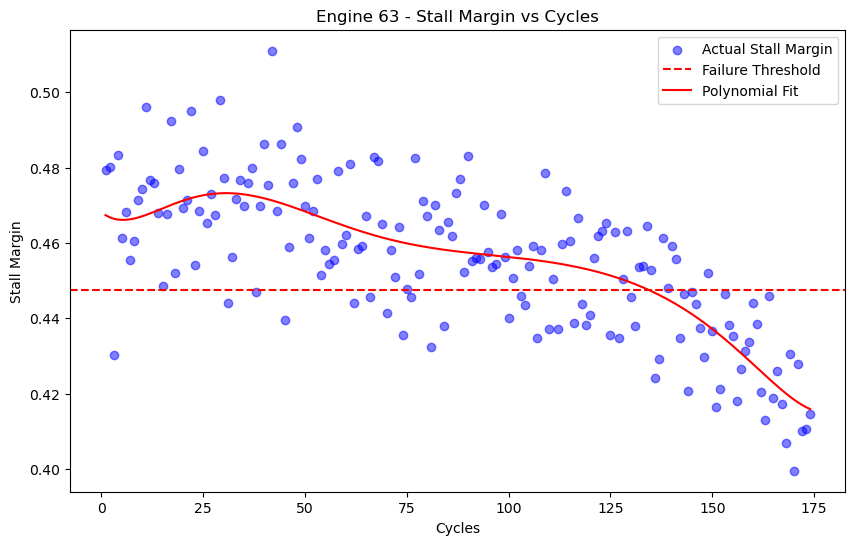

r2 score is:0.6588065785933186
Stall margin breaches the threshold at cycle 209, predicted value 0.4473651382314236


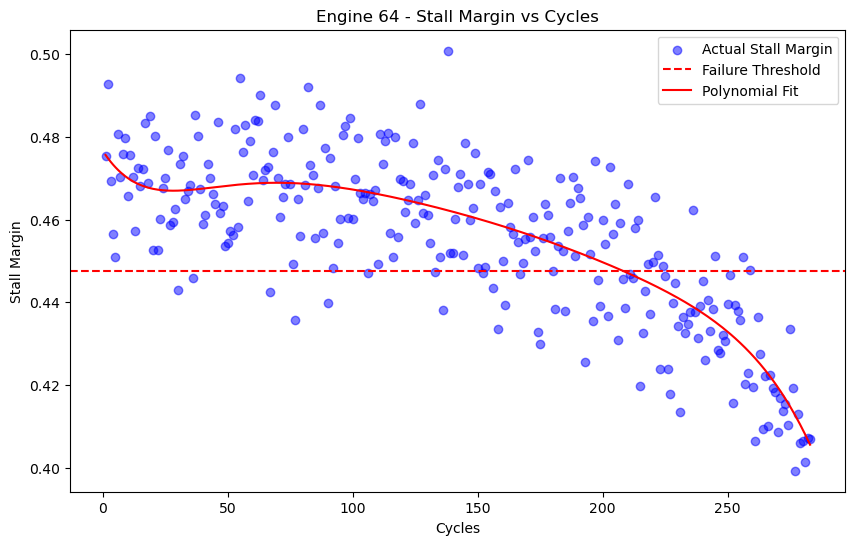

r2 score is:0.6550946673027731
Stall margin breaches the threshold at cycle 127, predicted value 0.446800458768229


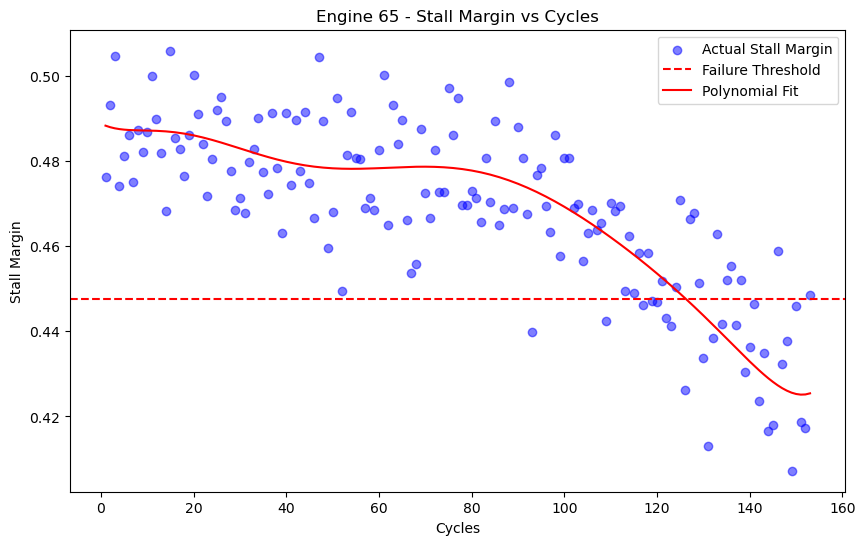

r2 score is:0.4985487734005358
Stall margin breaches the threshold at cycle 138, predicted value 0.44735458333004124


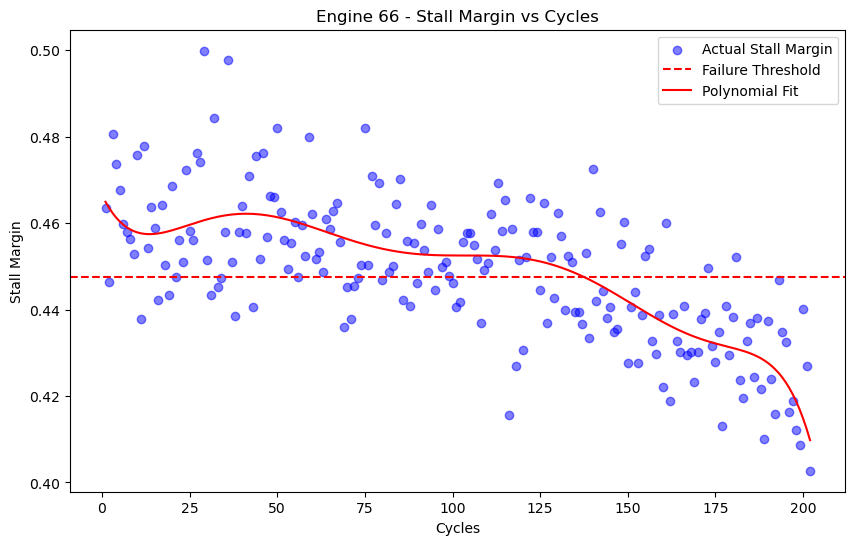

r2 score is:0.5683610131064869
Stall margin breaches the threshold at cycle 246, predicted value 0.4472518134133523


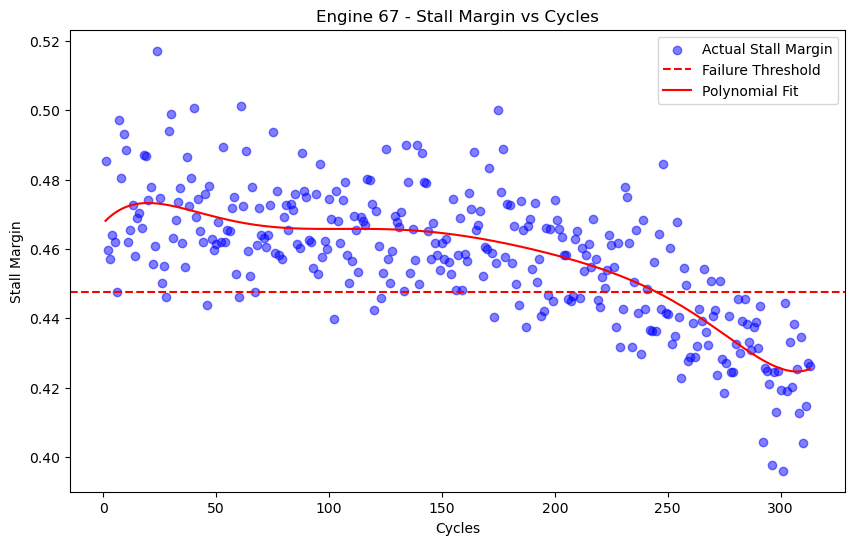

r2 score is:0.6276186305402024
Stall margin breaches the threshold at cycle 151, predicted value 0.44745017158282735


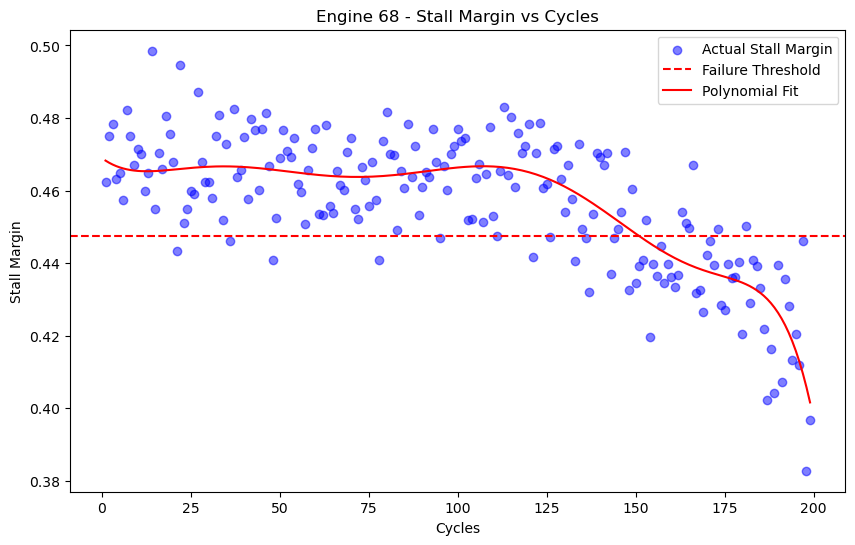

r2 score is:0.44567762129008803
Stall margin breaches the threshold at cycle 305, predicted value 0.4475048628637406


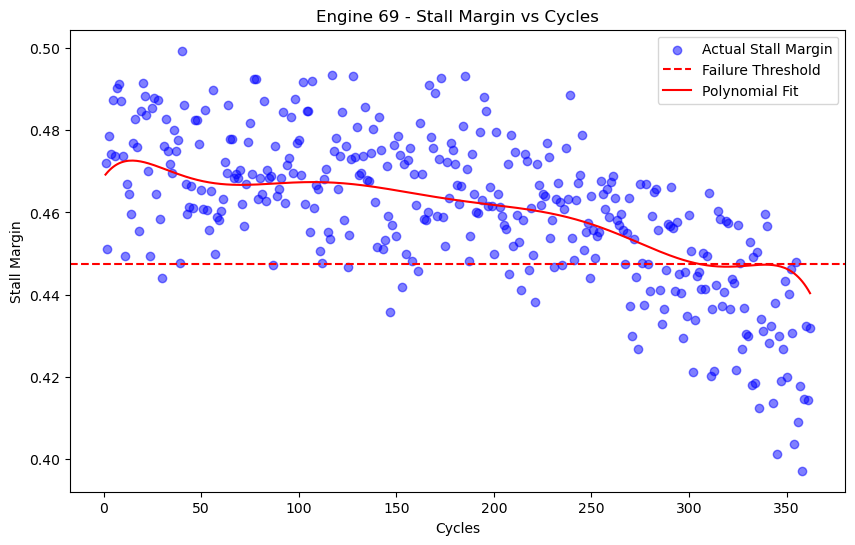

r2 score is:0.5625761330056789
Stall margin breaches the threshold at cycle 107, predicted value 0.4471150357745931


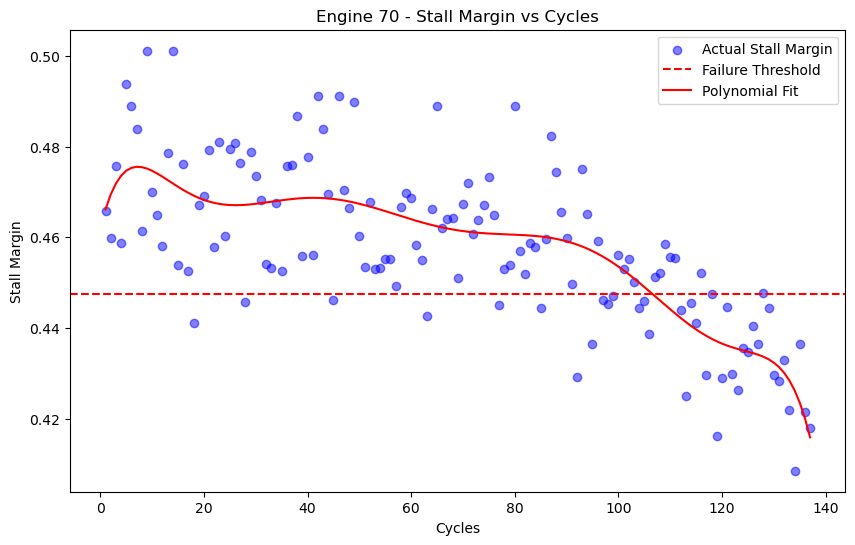

r2 score is:0.5169674882889198
Stall margin breaches the threshold at cycle 165, predicted value 0.4468805116967888


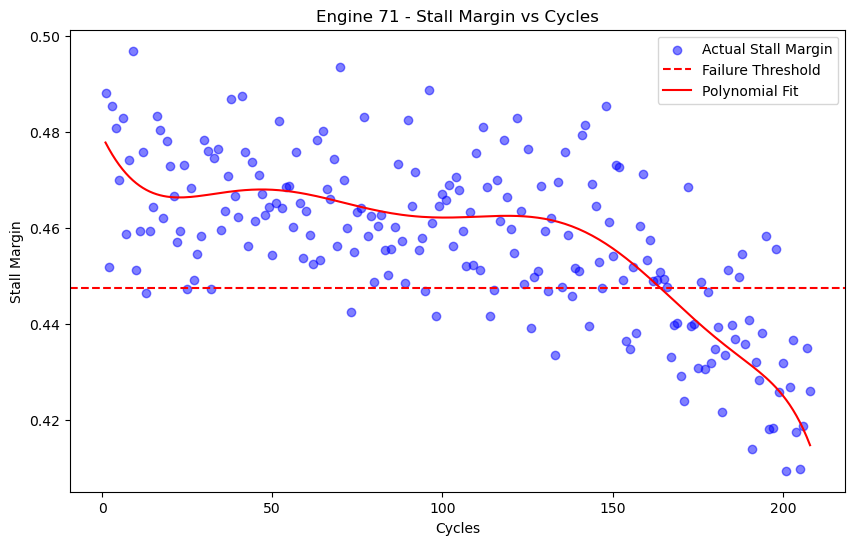

r2 score is:0.596336461902651
Stall margin breaches the threshold at cycle 180, predicted value 0.4474962045344486


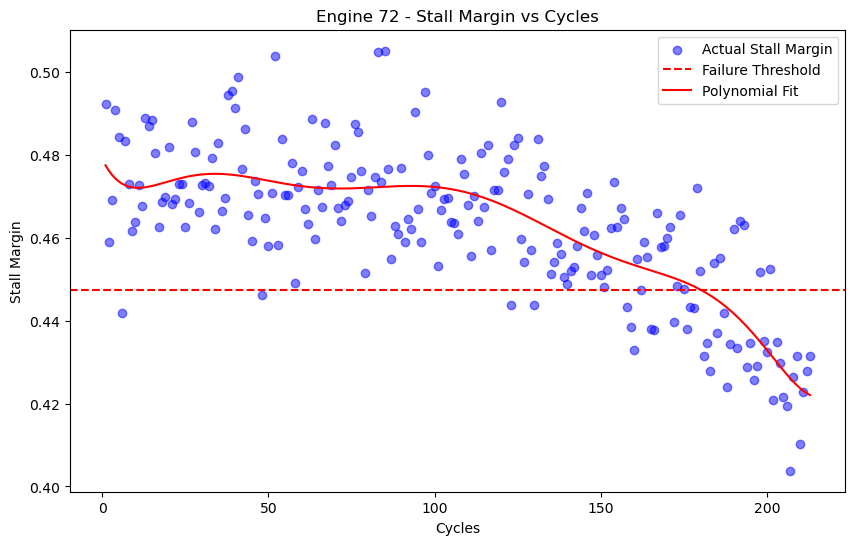

r2 score is:0.4247304237993771
Stall margin breaches the threshold at cycle 138, predicted value 0.447225632637984


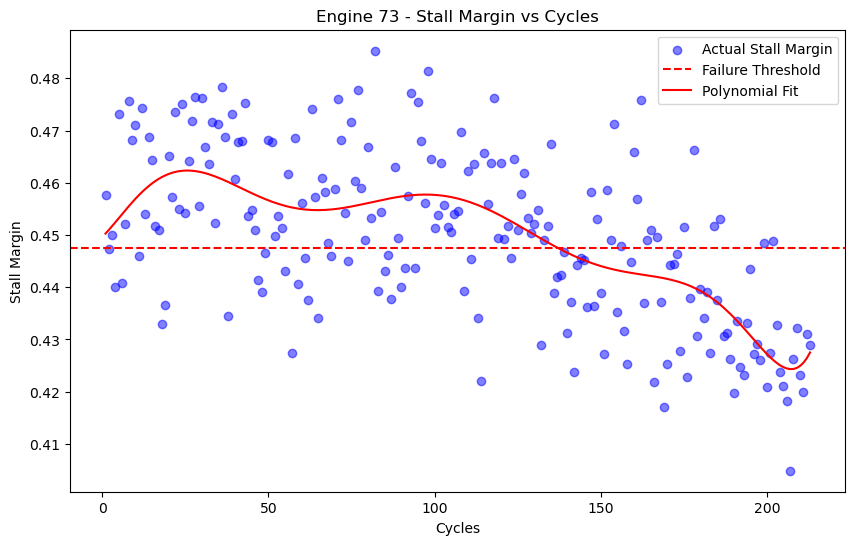

r2 score is:0.5089523811645575
Stall margin breaches the threshold at cycle 136, predicted value 0.44716561424487883


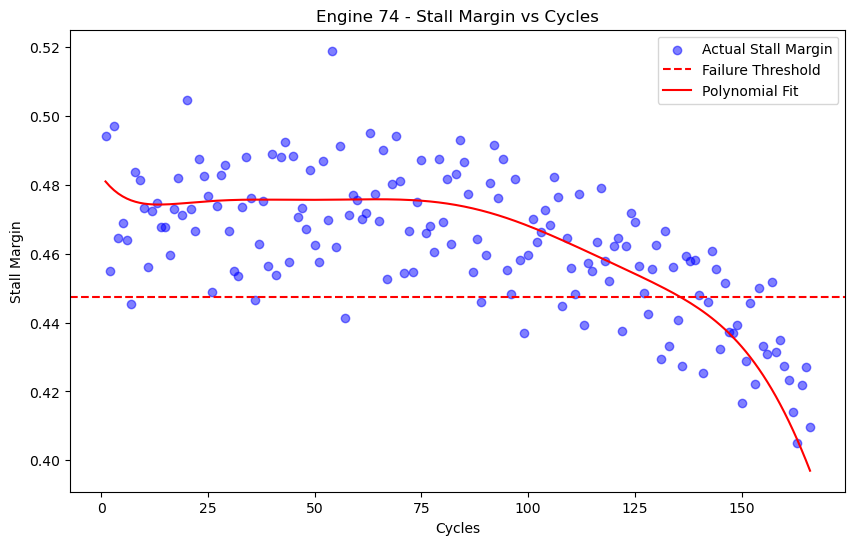

r2 score is:0.46988366015748095
Stall margin breaches the threshold at cycle 175, predicted value 0.44723524491268063


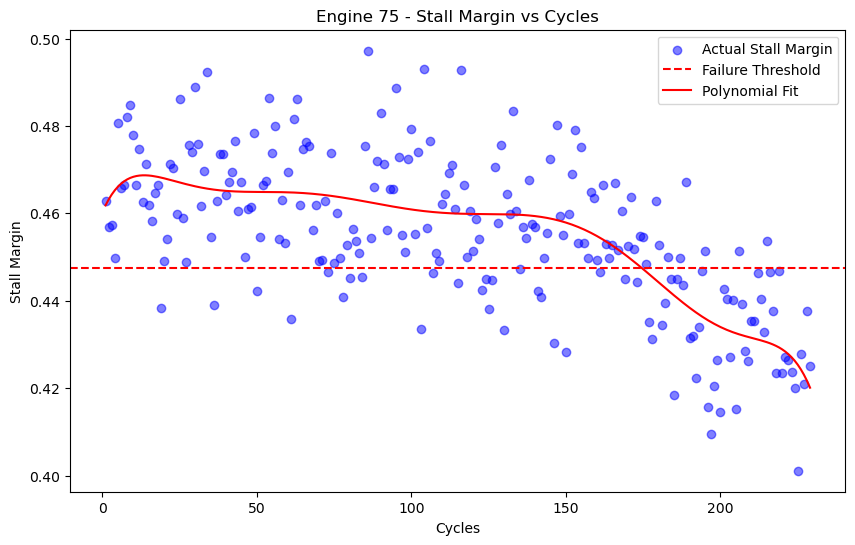

r2 score is:0.44744946456953316
Stall margin breaches the threshold at cycle 153, predicted value 0.44735216572801745


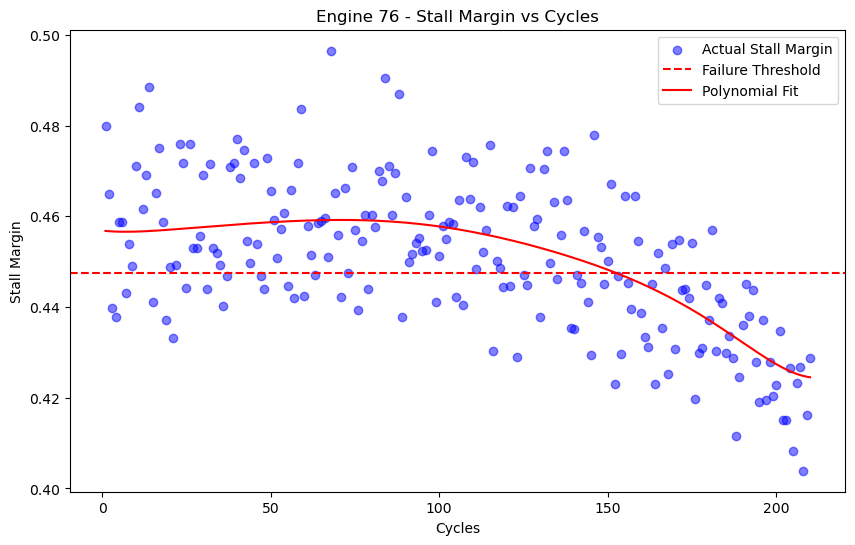

r2 score is:0.535429421554865
Stall margin breaches the threshold at cycle 123, predicted value 0.4471407709119835


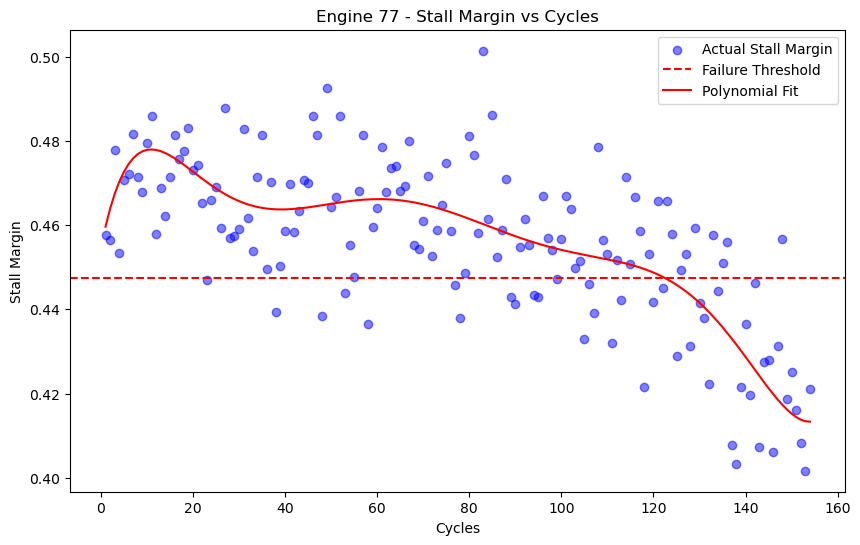

r2 score is:0.6624747426441024
Stall margin breaches the threshold at cycle 203, predicted value 0.4469831524115363


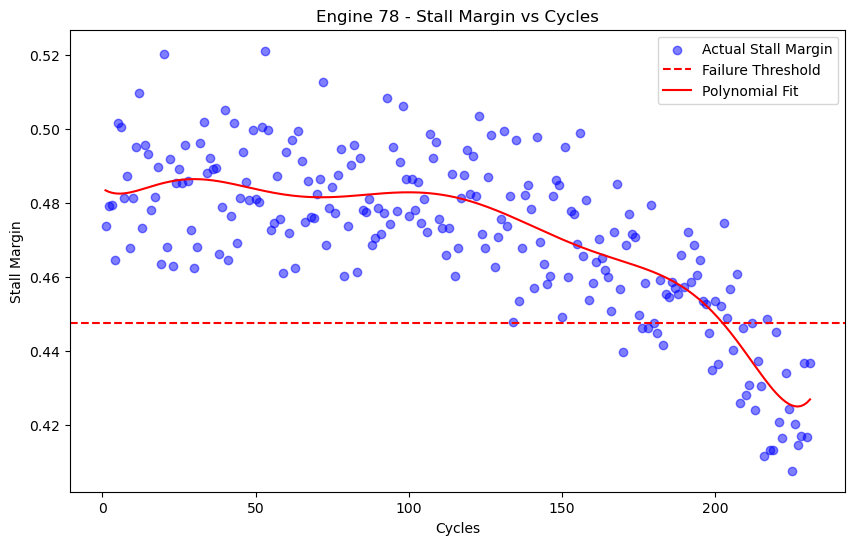

r2 score is:0.7036576894776368
Stall margin breaches the threshold at cycle 170, predicted value 0.44730707525916735


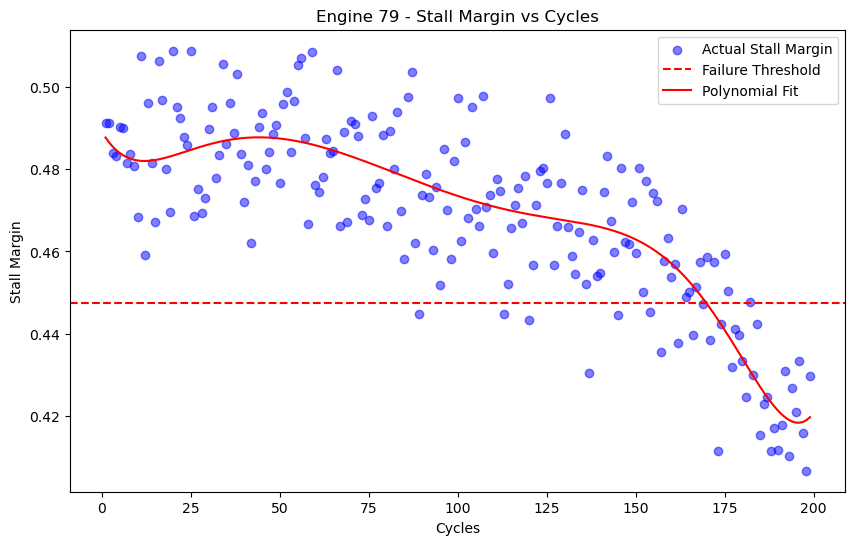

r2 score is:0.544618649738976
Stall margin breaches the threshold at cycle 140, predicted value 0.44749823668276345


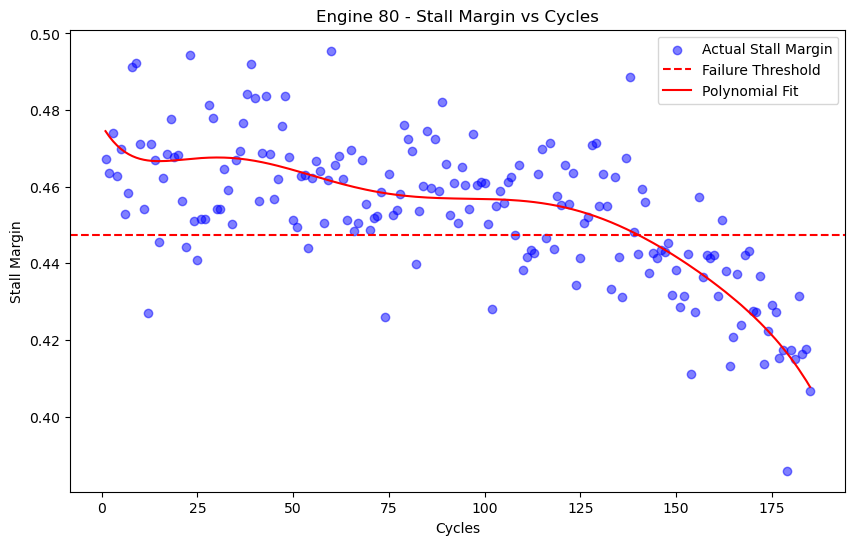

r2 score is:0.5216574418688915
Stall margin breaches the threshold at cycle 182, predicted value 0.4473626598419545


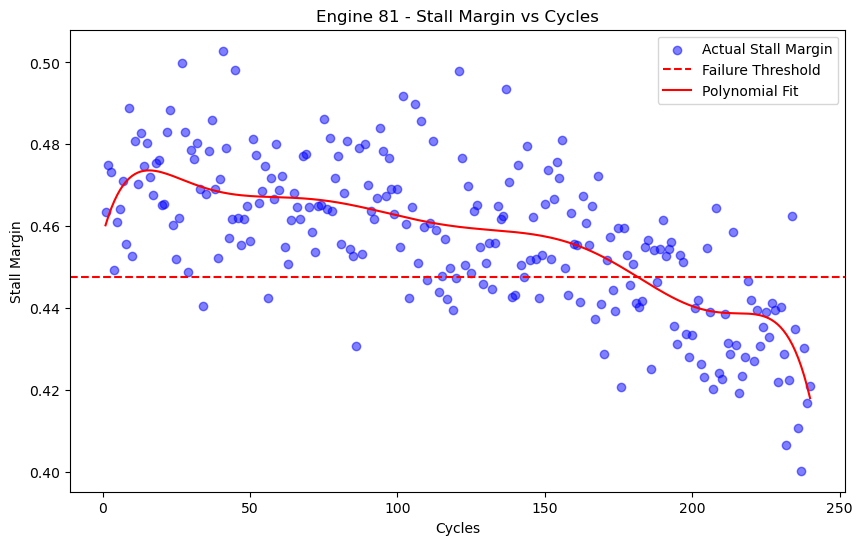

r2 score is:0.6439214283579313
Stall margin breaches the threshold at cycle 184, predicted value 0.4474759989721923


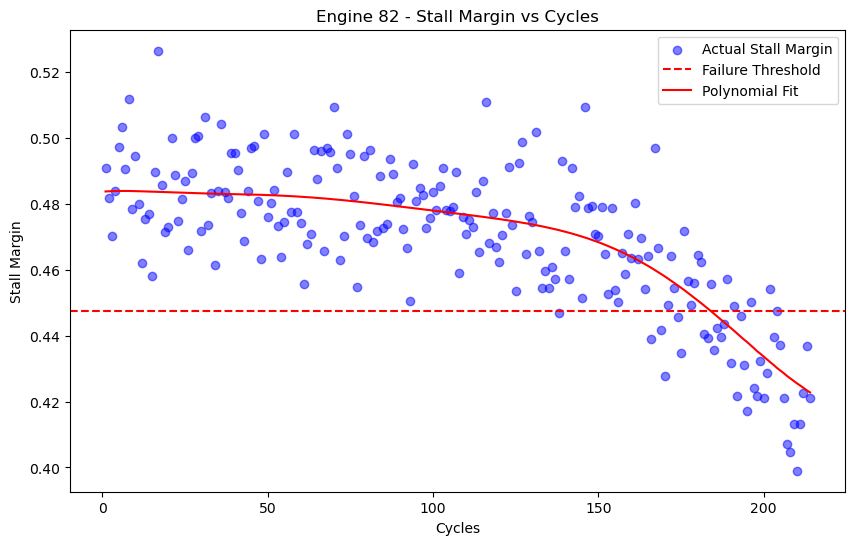

r2 score is:0.6929191666586891
Stall margin breaches the threshold at cycle 252, predicted value 0.447402208612018


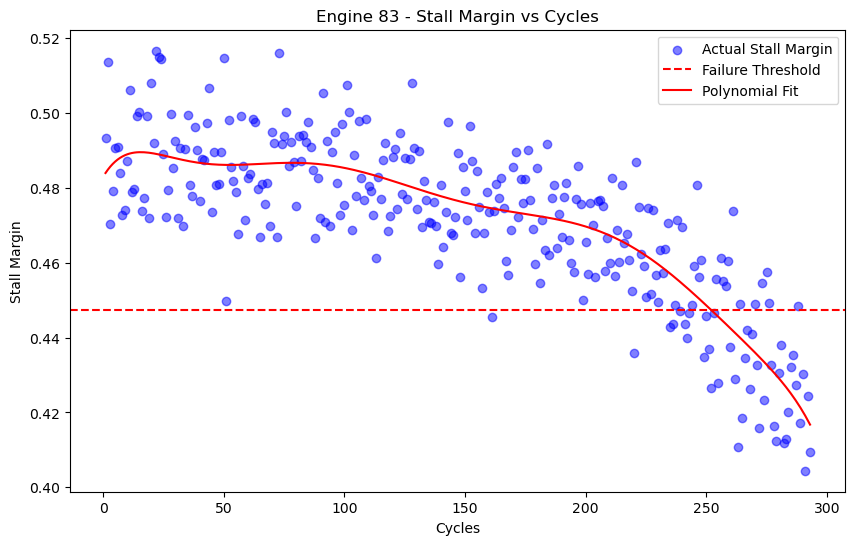

r2 score is:0.48638546754200795
Stall margin breaches the threshold at cycle 184, predicted value 0.4474769613401576


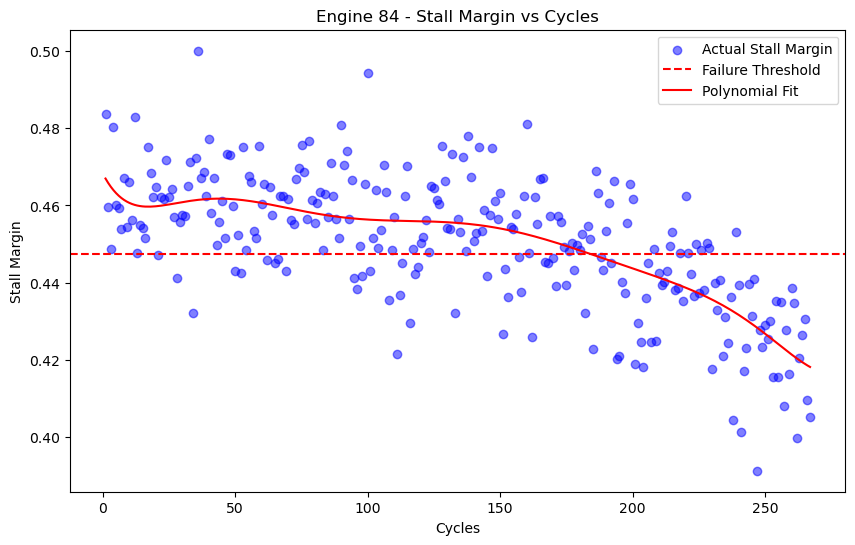

r2 score is:0.5278051548503413
Stall margin breaches the threshold at cycle 154, predicted value 0.447064819154514


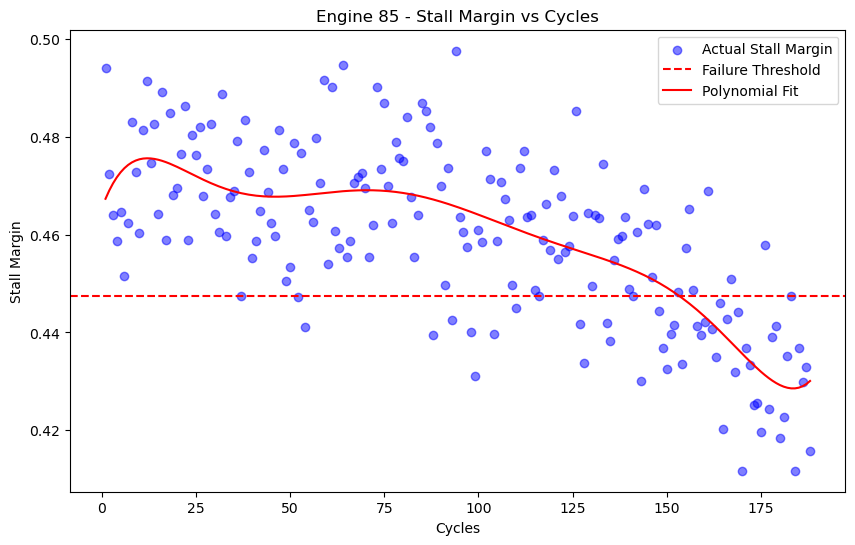

r2 score is:0.46723433324616015
Stall margin breaches the threshold at cycle 216, predicted value 0.44738239443457467


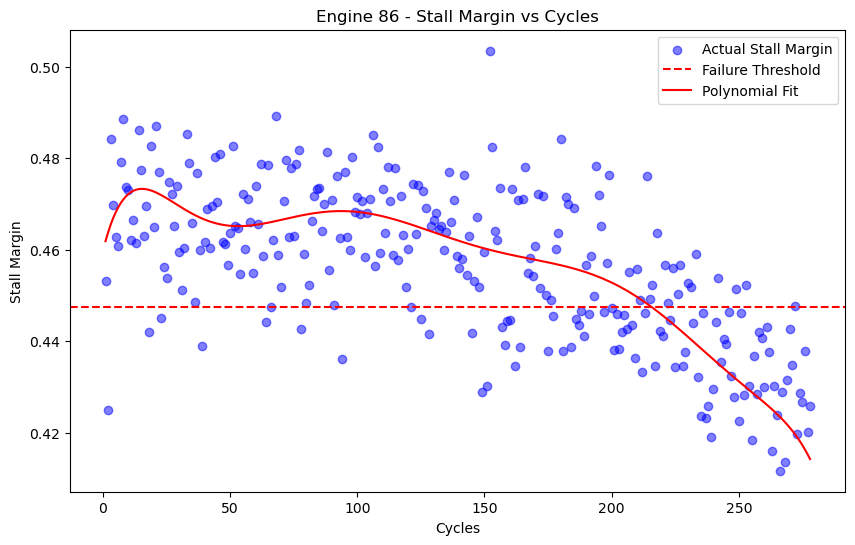

r2 score is:0.577897511920169
Stall margin breaches the threshold at cycle 141, predicted value 0.4473278405402847


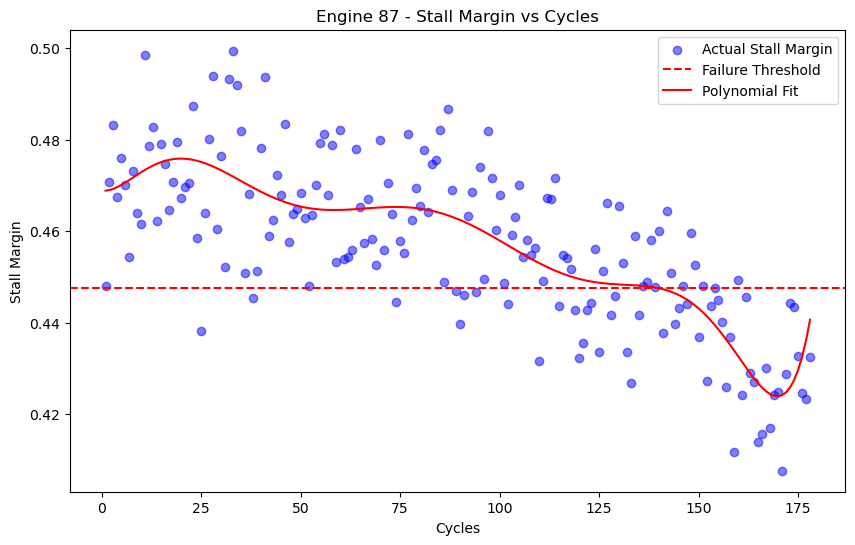

r2 score is:0.5633147019878142
Stall margin breaches the threshold at cycle 171, predicted value 0.44709769431035884


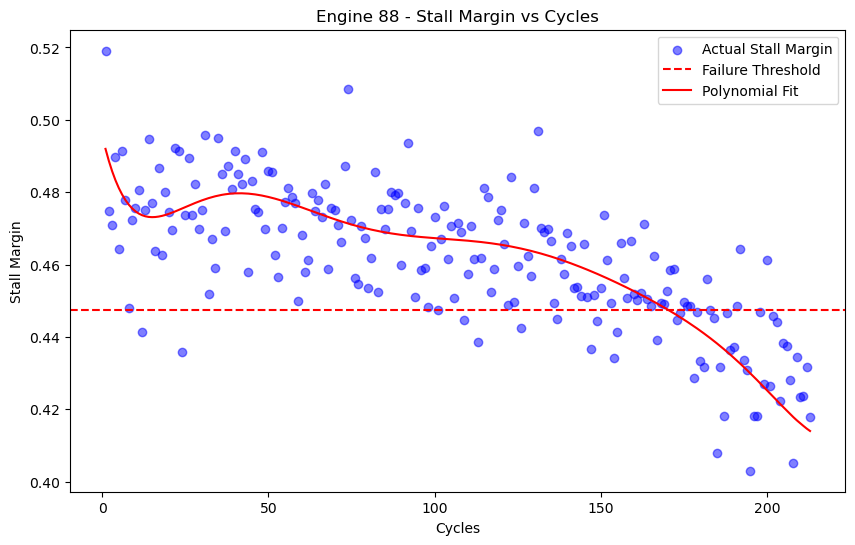

r2 score is:0.6387466479755992
Stall margin breaches the threshold at cycle 186, predicted value 0.44747500605859836


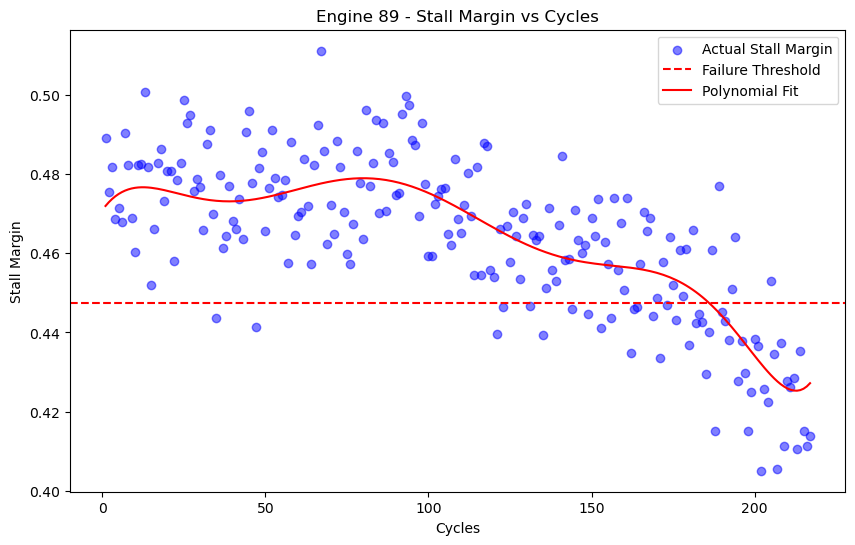

r2 score is:0.6434258682492564
Stall margin breaches the threshold at cycle 129, predicted value 0.44707995068407264


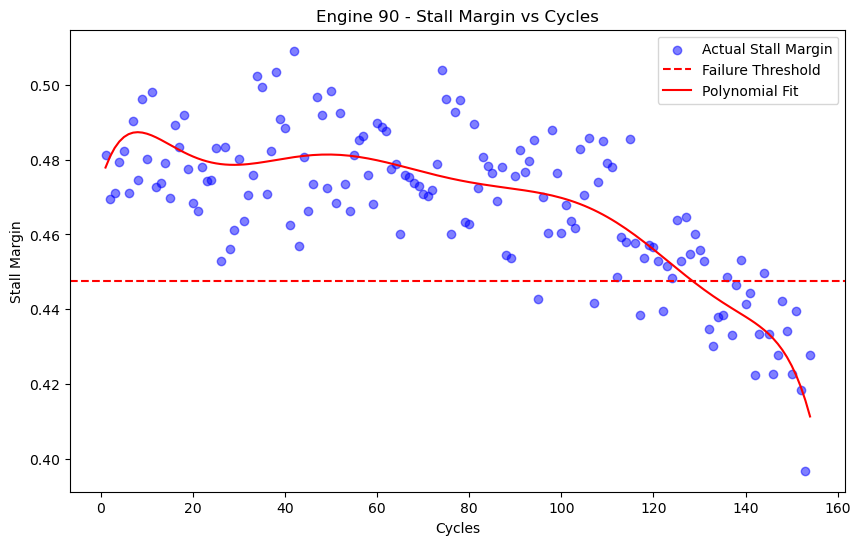

r2 score is:0.4411748793137733
Stall margin breaches the threshold at cycle 74, predicted value 0.4474991779463429


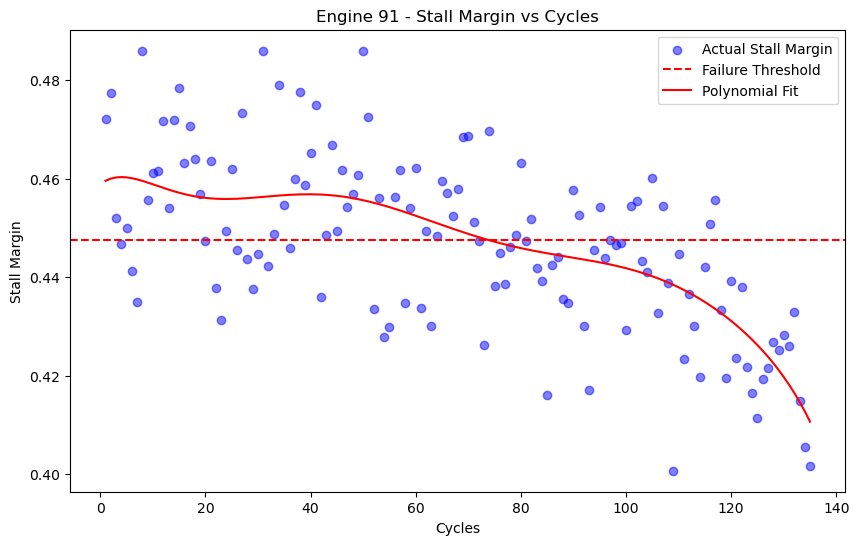

r2 score is:0.6271305103567761
Stall margin breaches the threshold at cycle 276, predicted value 0.44724438006548295


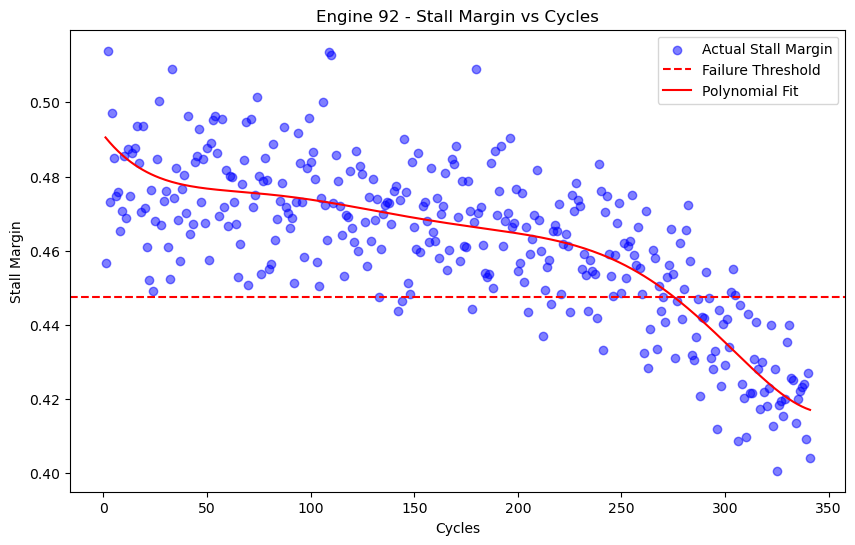

r2 score is:0.631158621774986
Stall margin breaches the threshold at cycle 132, predicted value 0.44698678941378267


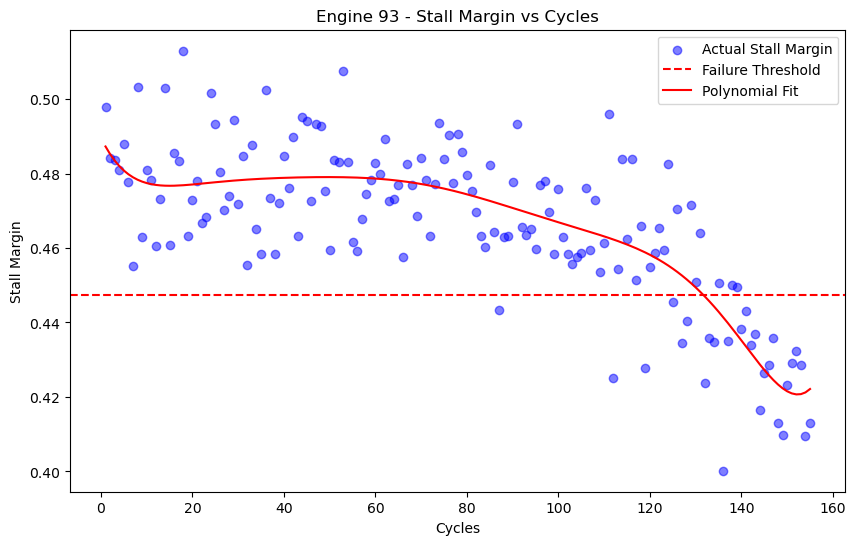

r2 score is:0.4828467413339915
Stall margin breaches the threshold at cycle 205, predicted value 0.44715017551410147


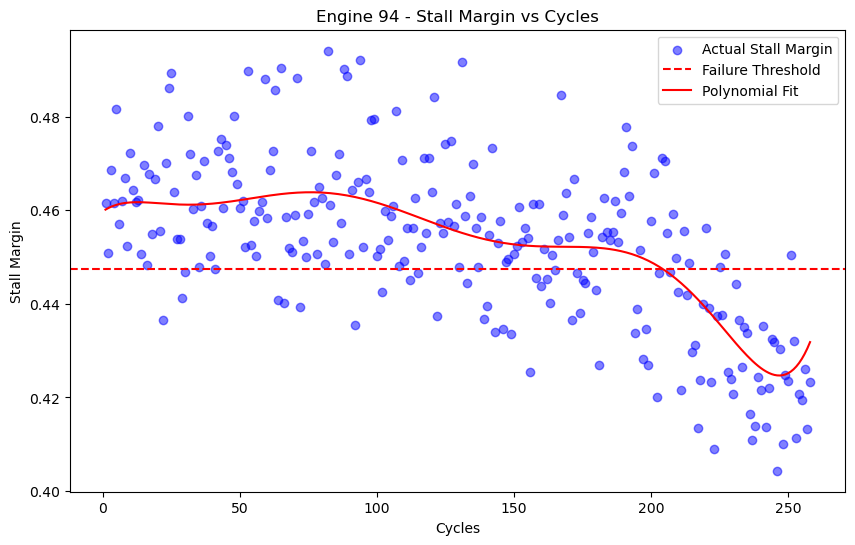

r2 score is:0.6439550342100561
Stall margin breaches the threshold at cycle 243, predicted value 0.44742277044966194


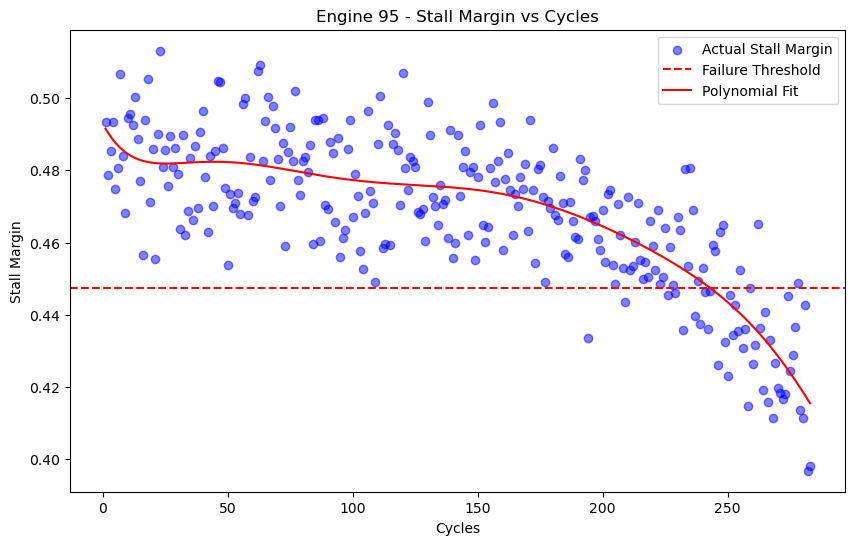

r2 score is:0.6269733236172835
Stall margin breaches the threshold at cycle 272, predicted value 0.4471263655142572


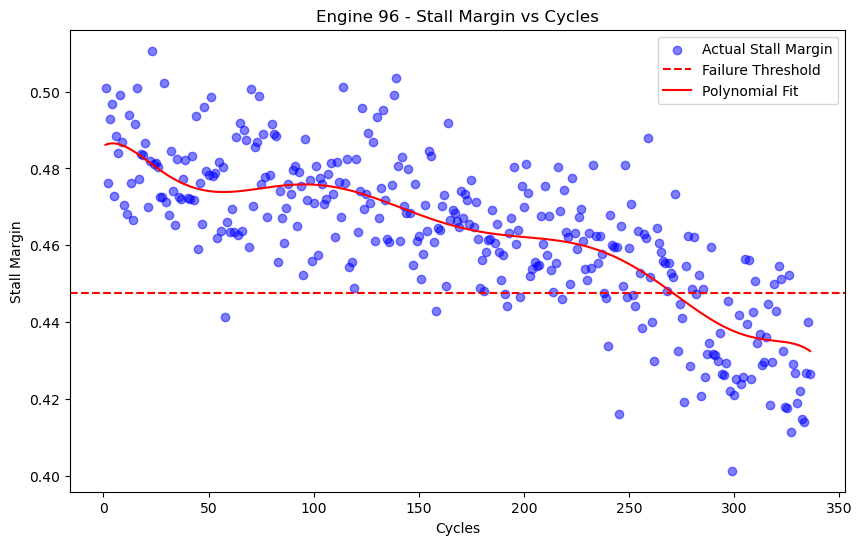

r2 score is:0.6050696169269455
Stall margin breaches the threshold at cycle 179, predicted value 0.4469501983260099


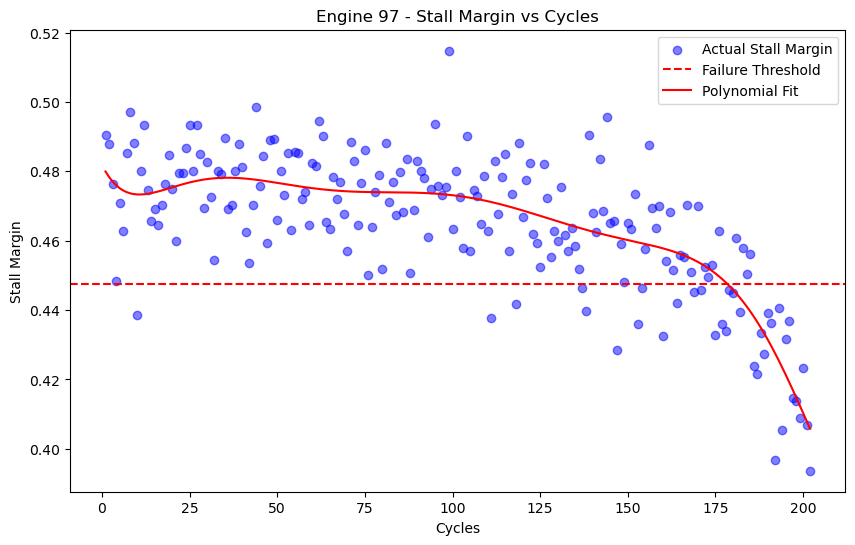

r2 score is:0.6701797658178033
Stall margin breaches the threshold at cycle 133, predicted value 0.4473296956065094


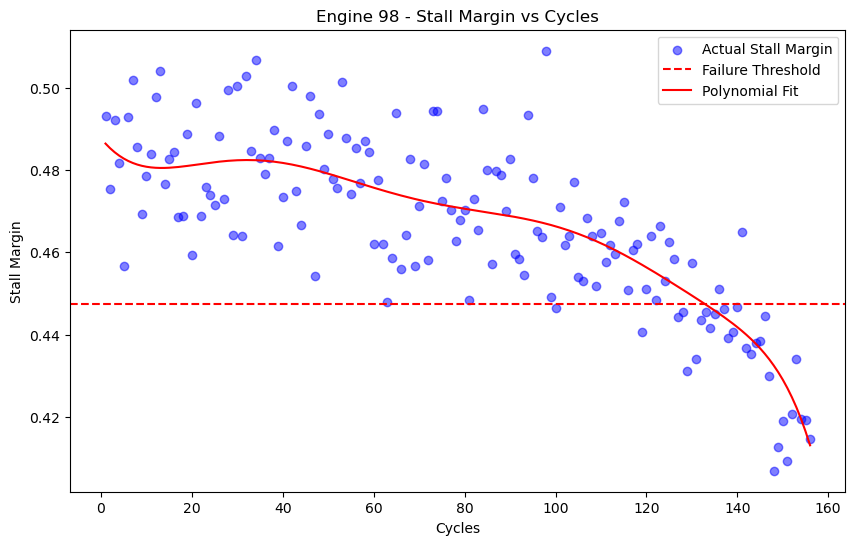

r2 score is:0.6344003746532378
Stall margin breaches the threshold at cycle 161, predicted value 0.447089908441626


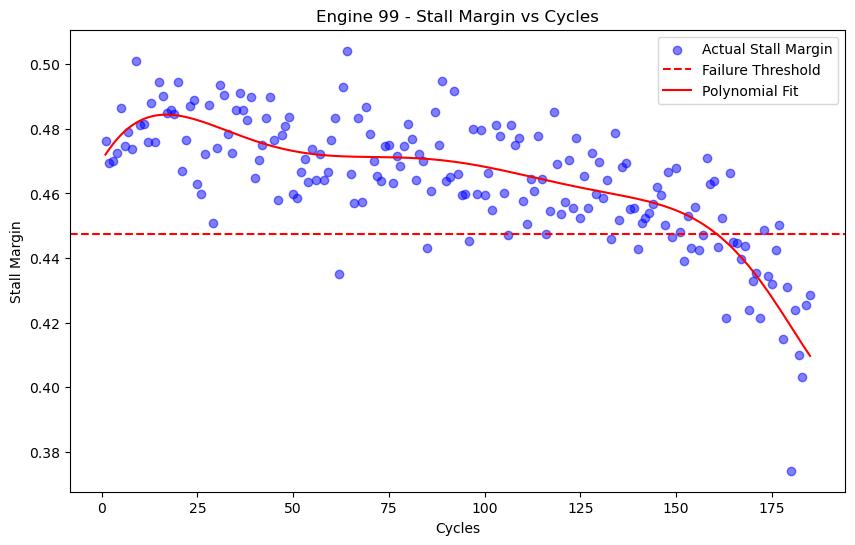

r2 score is:0.6135137335608389
Stall margin breaches the threshold at cycle 151, predicted value 0.44708326909175966


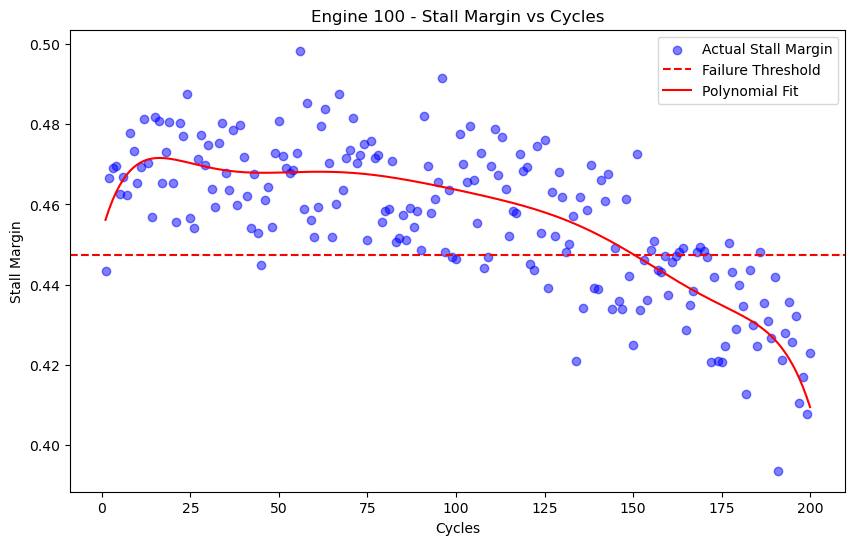

In [18]:
 #Get a list of unique engine numbers
unique_engines = FD001_data['Engine'].unique()

# Initialize a list to store results
engine_results = []

r2_scores_data = []

# Loop through each engine and fit a model
for engine in unique_engines:
    # Filter data for the current engine
    engine_data = FD001_data[FD001_data['Engine'] == engine]
    
    # Adding Features so that model can capture variance in the data effectively for HPC failure
    X = engine_data[['Cycles','Baseline_Efficiency','Initial_Wear_HPT_Efficiency','Initial_Wear_HPT_Flow','Wear_HPT_Efficiency_3000','Wear_HPT_Flow_3000','Wear_HPT_Efficiency_6000','Wear_HPT_Flow_6000','Engine pressure ratioP50/P2']]
    y = engine_data['stall_margin']
    
    #Creating poly model
    poly = PolynomialFeatures(degree=8)
    X_poly = poly.fit_transform(X)
    model = LinearRegression(fit_intercept=True).fit(X_poly, y)
    
    # Predict the stall margin using the model
    y_pred = model.predict(X_poly)



    #Calculate R2 score
    r2_poly_agg = r2_score(y,y_pred)
    print(f'r2 score is:{r2_poly_agg}')
    r2_scores_data.append(r2_poly_agg)

    # Find the first cycle where the predicted stall margin falls below the threshold
    breach_index = np.where(y_pred <= stall_margin_failure_threshold)[0][0]
    breach_cycle = engine_data['Cycles'].values[breach_index]

    # Print the cycle and stall margin at breach
    print(f"Stall margin breaches the threshold at cycle {breach_cycle}, predicted value {y_pred[breach_index]}")

        # Store the model and data
    engine_results.append({
        'engine': engine,
        'model': model,
        'X_poly': X_poly,
        'y': y,
        'y-hat': y_pred,
        'breach_index': breach_index,
        'breach_cycle': breach_cycle
    })
   
    
    # Scatter plot for actual stall margin vs cycles
    plt.figure(figsize=(10, 6))
    plt.scatter(engine_data['Cycles'], y, color='blue', alpha=0.5, label='Actual Stall Margin')
    plt.axhline(stall_margin_failure_threshold, color='red', linestyle='--', label='Failure Threshold')
    plt.plot(engine_data['Cycles'], y_pred, color='red', label='Polynomial Fit')
    plt.title(f'Engine {engine} - Stall Margin vs Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Stall Margin')
    plt.legend()
    plt.show()


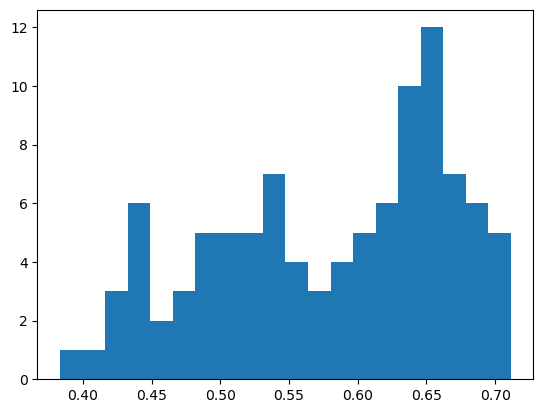

In [19]:
#Getting an understanding of my overall R2 score and how well my models understand the spread of the data. 
plt.hist(r2_scores_data,bins=20)
plt.show()

In [20]:
#Creating RUL based on observations above
for result in engine_results:
    print(result['engine'])
    for stallmargin in result['y-hat']:
        if stallmargin < stall_margin_failure_threshold:
            print(stallmargin)
            break
        
    


1
0.4468942799162093
2
0.44739371934268485
3
0.44707609207734184
4
0.4471915280723411
5
0.4474772505811432
6
0.4472149763650411
7
0.44731503607929485
8
0.4474882295564429
9
0.4464867837843991
10
0.4474652613662203
11
0.44701009863507957
12
0.44741533952087725
13
0.4472225529805977
14
0.4473553161434261
15
0.44701700172963116
16
0.4473809154945003
17
0.44718058733858096
18
0.4474399577017144
19
0.4471160802350558
20
0.4472676304262653
21
0.4473038177497031
22
0.4473128094188817
23
0.4472149647391742
24
0.4466000826756468
25
0.44749269201316844
26
0.4473936192195221
27
0.44726586127964796
28
0.44689985932903165
29
0.44732967471131996
30
0.44706123536813974
31
0.4467458139993371
32
0.44731512906952137
33
0.44719804267965235
34
0.44695826694838064
35
0.44689479537432397
36
0.44737885749529
37
0.4473133923982545
38
0.4474740046600076
39
0.44737304151879065
40
0.4473642996553841
41
0.44745373998313026
42
0.4472113646443549
43
0.44723760903128384
44
0.4471008931371839
45
0.44721589183532817
4

In [21]:
#FD001_data['RUL'] = (stall_margin - stall_margin_failure_threshold)

max_engine_cycles = FD001_data.groupby("Engine")[['Cycles']].agg(max)
print(type(max_engine_cycles.info()))
print(max_engine_cycles)

print(type(max_engine_cycles))



<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 1 to 100
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Cycles  100 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB
<class 'NoneType'>
        Cycles
Engine        
1          192
2          287
3          179
4          189
5          269
...        ...
96         336
97         202
98         156
99         185
100        200

[100 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
